<b><h1>Books Recommendation System

In [94]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

<b><h3>Dataset

In [95]:
books = pd.read_csv(r"Datasets/Books.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv(r"Datasets/Users.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv(r"Datasets/Book-Ratings.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


<b><h3>Pre-processing

<b>Books Dataset Pre-processing

In [96]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [97]:
# Hàm xử lý năm xuất bản
def fix_publication_year(year):
    # Kiểm tra xem năm có phải số nguyên không
    if isinstance(year, (int, float)) and not np.isnan(year):
        # Kiểm tra năm trong khoảng hợp lý (1800-2024)
        if 1800 <= year <= 2024:
            return int(year)
    
    # Kiểm tra nếu là chuỗi, thử chuyển đổi
    if isinstance(year, str):
        # Trích xuất 4 chữ số liên tiếp có thể là năm
        year_match = re.search(r'(19|20)\d{2}', year)
        if year_match:
            year_num = int(year_match.group())
            if 1800 <= year_num <= 2024:
                return year_num
    
    # Nếu không thể xác định năm hợp lệ
    return np.nan

# Áp dụng hàm sửa năm xuất bản
books['Year-Of-Publication'] = books['Year-Of-Publication'].apply(fix_publication_year)

# Điền giá trị thiếu bằng median
median_year = int(books['Year-Of-Publication'].dropna().median())
print(f"Điền các năm xuất bản thiếu/không hợp lệ bằng giá trị trung vị: {median_year}")
books['Year-Of-Publication'] = books['Year-Of-Publication'].fillna(median_year)
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

Điền các năm xuất bản thiếu/không hợp lệ bằng giá trị trung vị: 1996


In [98]:
def clean_isbn(isbn):
    if isinstance(isbn, str):
        # Xóa ký tự đặc biệt, giữ lại chữ và số
        cleaned = re.sub(r'[^A-Za-z0-9]', '', isbn)
        return cleaned.upper()  # Chuyển về chữ hoa
    return isbn

# Áp dụng hàm chuẩn hóa ISBN
books['ISBN'] = books['ISBN'].apply(clean_isbn)
ratings['ISBN'] = ratings['ISBN'].apply(clean_isbn)

# In thông tin về trùng lặp
print(f"Số lượng sách trước khi xử lý trùng lặp: {len(books)}")
books = books.drop_duplicates(subset=['ISBN'], keep='first')
print(f"Số lượng sách sau khi xử lý trùng lặp: {len(books)}")

Số lượng sách trước khi xử lý trùng lặp: 271360
Số lượng sách sau khi xử lý trùng lặp: 271045


In [99]:
## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [100]:
## Checking for null values
books.isnull().sum() 

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [101]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [102]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [103]:
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [104]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 1911, 1904,
       1949, 1932, 1928, 1929, 1927, 1931, 1914, 1934, 1910, 1933, 1902,
       1924, 1921, 1900, 1944, 1917, 1901, 2010, 1908, 1906, 1935, 1806,
       2021, 2012, 2006, 1909, 2008, 1919, 1922, 2024])

In [105]:
pd.set_option('display.max_colwidth', -1)

In [106]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [107]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [108]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [109]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [110]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[1806, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024]


In [111]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[1996]

In [112]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [113]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [114]:
def clean_author_name(name):
    if pd.isna(name) or name == "":
        return "Unknown Author"
    
    if isinstance(name, str):
        # Xóa dấu ngoặc và nội dung trong đó
        cleaned = re.sub(r'\([^)]*\)', '', name)
        # Chuẩn hóa khoảng trắng
        cleaned = ' '.join(cleaned.split())
        return cleaned
    return name

# Áp dụng hàm chuẩn hóa tên tác giả
books['Book-Author'] = books['Book-Author'].apply(clean_author_name)

# Thêm đặc trưng
books['Title-Length'] = books['Book-Title'].str.len()
books['Decade'] = (books['Year-Of-Publication'] // 10) * 10

print("Hoàn thành cải thiện tiền xử lý dữ liệu!")
books.info()

Hoàn thành cải thiện tiền xử lý dữ liệu!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 271045 entries, 0 to 271359
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271045 non-null  object
 1   Book-Title           271045 non-null  object
 2   Book-Author          271045 non-null  object
 3   Year-Of-Publication  271045 non-null  int32 
 4   Publisher            271045 non-null  object
 5   Title-Length         271045 non-null  int64 
 6   Decade               271045 non-null  int32 
dtypes: int32(2), int64(1), object(4)
memory usage: 22.5+ MB


In [115]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [116]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271045 entries, 0 to 271044
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271045 non-null  object
 1   Book-Title           271045 non-null  object
 2   Book-Author          271045 non-null  object
 3   Year-Of-Publication  271045 non-null  int32 
 4   Publisher            271045 non-null  object
 5   Title-Length         271045 non-null  int64 
 6   Decade               271045 non-null  int32 
dtypes: int32(2), int64(1), object(4)
memory usage: 12.4+ MB


In [117]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Title-Length,Decade
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,19,2000
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,12,2000
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,20,1990
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,98,1990
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,22,1990


<b>Users Dataset Pre-processing

In [118]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [119]:
## Checking null values
print(users.isna().sum())               

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [120]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [121]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [122]:
mean = round(required['Age'].mean())   
mean

35

In [123]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [124]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values 
print(count_no_state)     #printing the states which didnt have any values

4659
16044


In [125]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [126]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int32 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 9.6+ MB


In [127]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


<b>Books-Ratings Dataset Pre-processing

In [128]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [129]:
## Checking for null values
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [130]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [131]:
## checking User-ID contains only number or not
print(is_numeric_dtype(ratings['User-ID']))

True


In [132]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

True


In [133]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [134]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [135]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [136]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149774 entries, 0 to 1149773
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149774 non-null  int64 
 1   ISBN         1149774 non-null  object
 2   Book-Rating  1149774 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [137]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


<h3><b>Merging of all three Tables

<b>Merging Books, Users and Rating Tables in One

In [138]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031472 entries, 0 to 1031471
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031472 non-null  object
 1   Book-Title           1031472 non-null  object
 2   Book-Author          1031472 non-null  object
 3   Year-Of-Publication  1031472 non-null  int32 
 4   Publisher            1031472 non-null  object
 5   Title-Length         1031472 non-null  int64 
 6   Decade               1031472 non-null  int32 
 7   User-ID              1031472 non-null  int64 
 8   Book-Rating          1031472 non-null  int64 
 9   Age                  1031472 non-null  int32 
 10  City                 1031472 non-null  object
 11  State                1031472 non-null  object
 12  Country              1031472 non-null  object
dtypes: int32(3), int64(3), object(7)
memory usage: 98.4+ MB


<b>Divide complete data on the basis of Implicit and Explicit ratings datasets

In [139]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384024, 13)

In [140]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647448, 13)

In [141]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Title-Length,Decade,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,12,2000,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,39,2000,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,18,2000,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,1990,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,44,1990,8,6,35,timmins,ontario,canada


<h3><b>Data Visualization

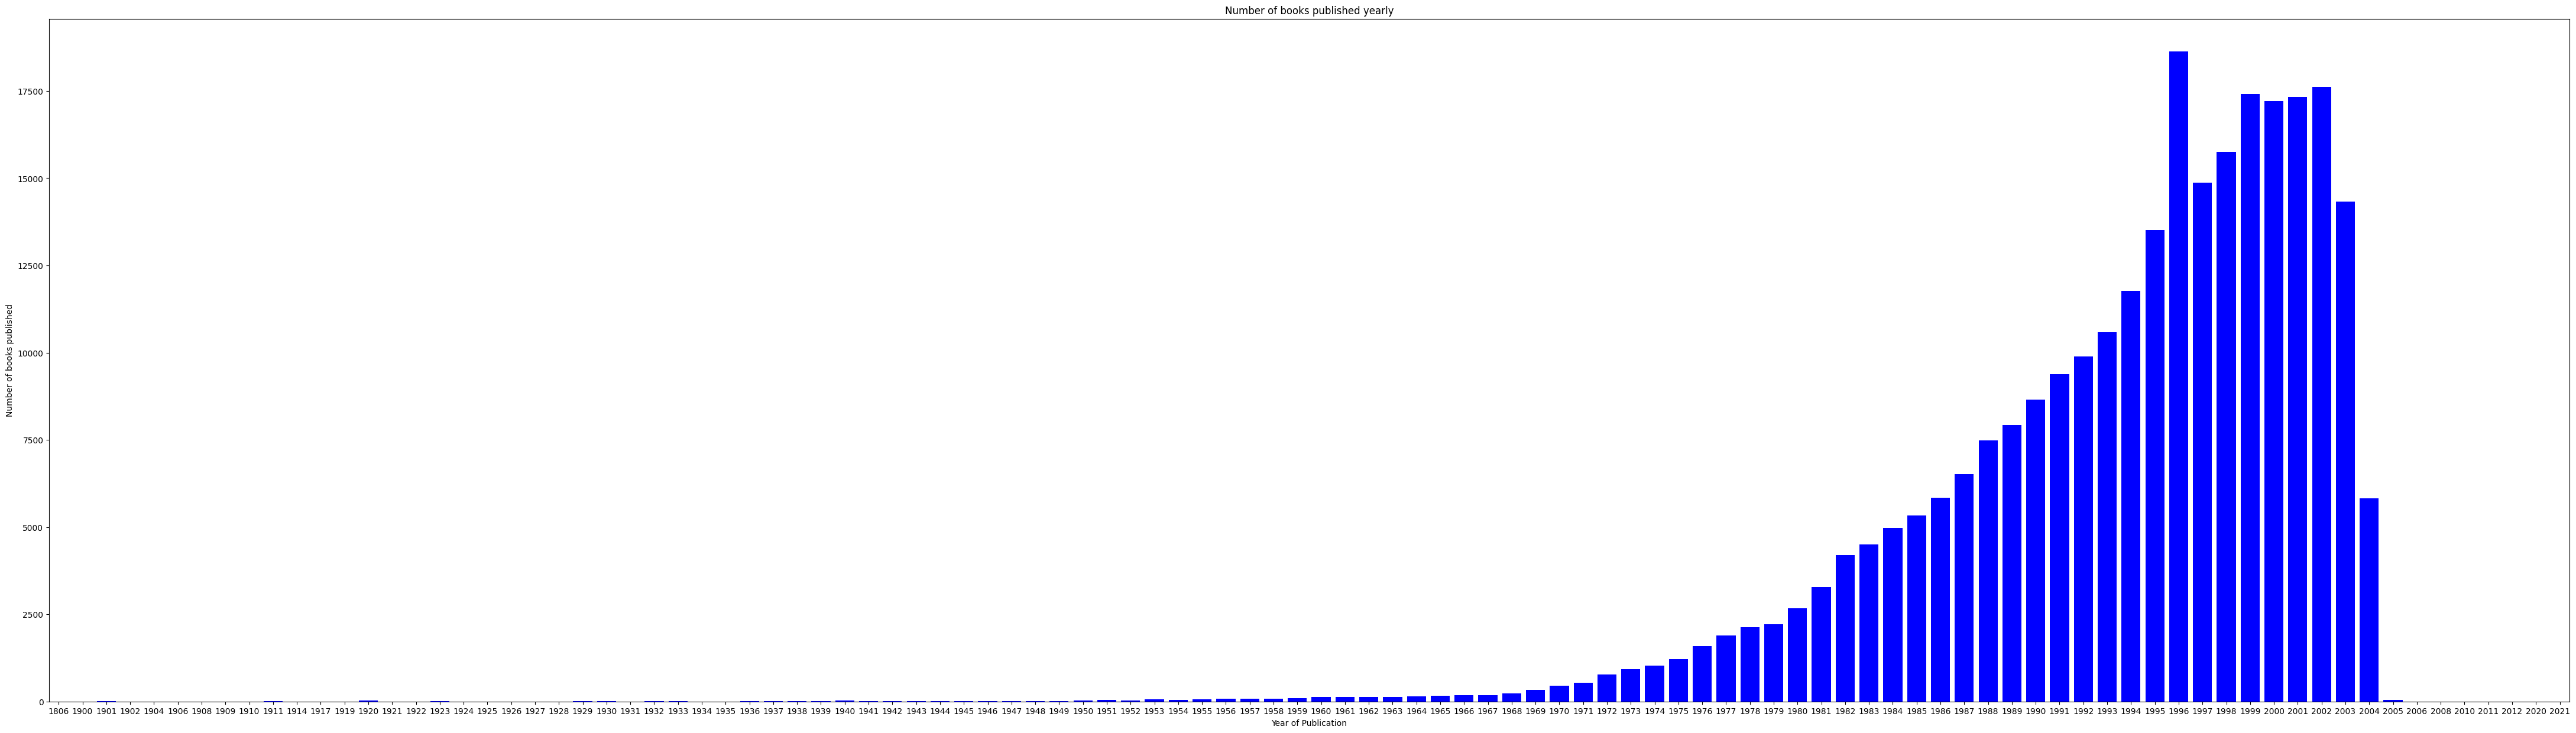

In [142]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

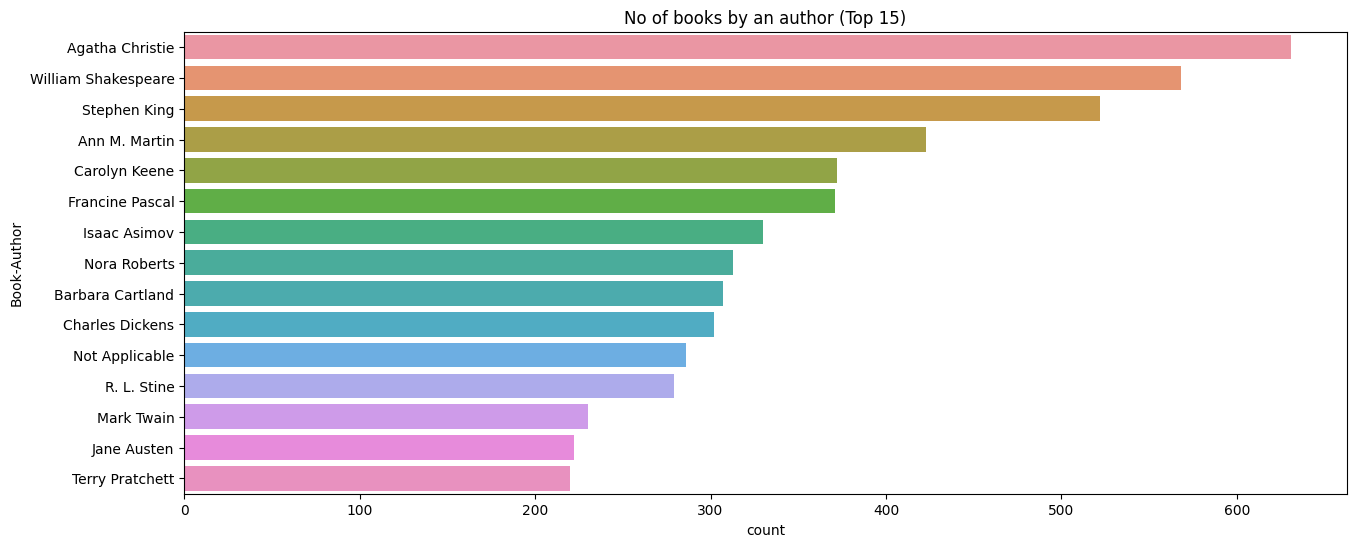

In [143]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

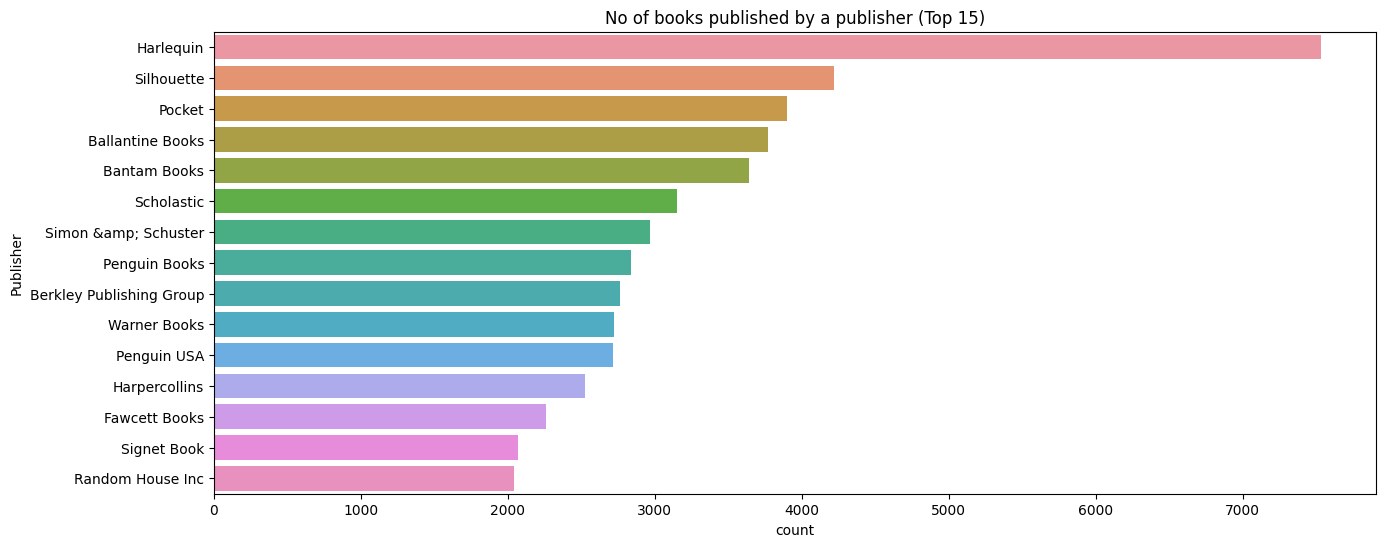

In [144]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

<AxesSubplot: xlabel='Book-Rating', ylabel='count'>

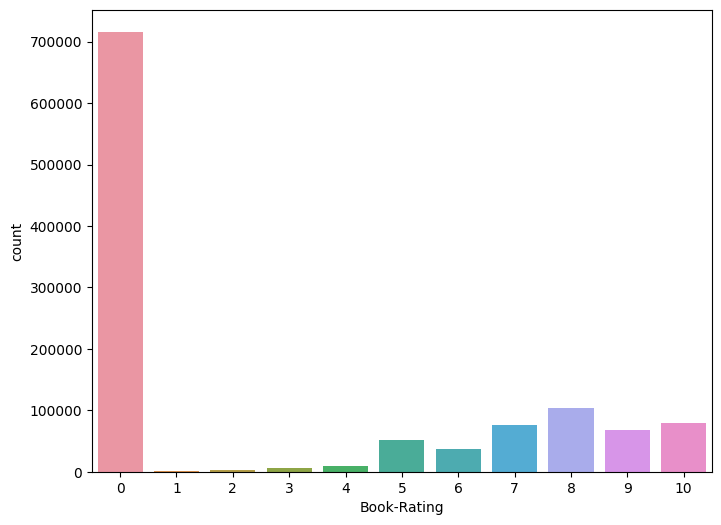

In [145]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

Text(0.5, 1.0, 'Explicit Ratings')

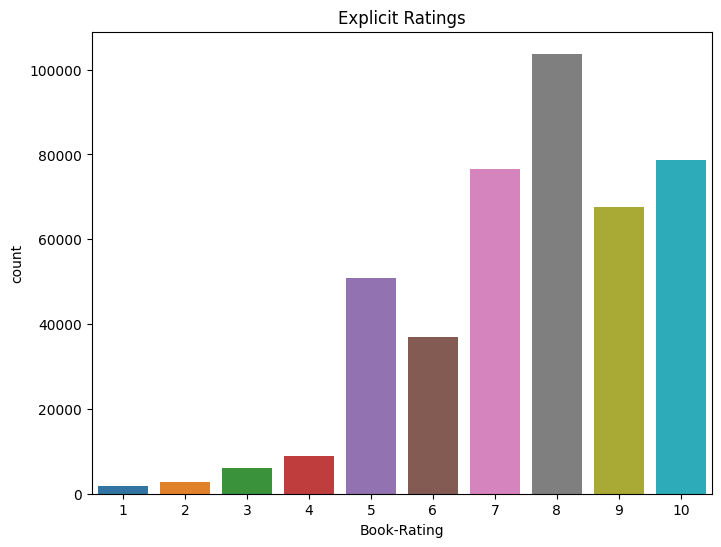

In [146]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

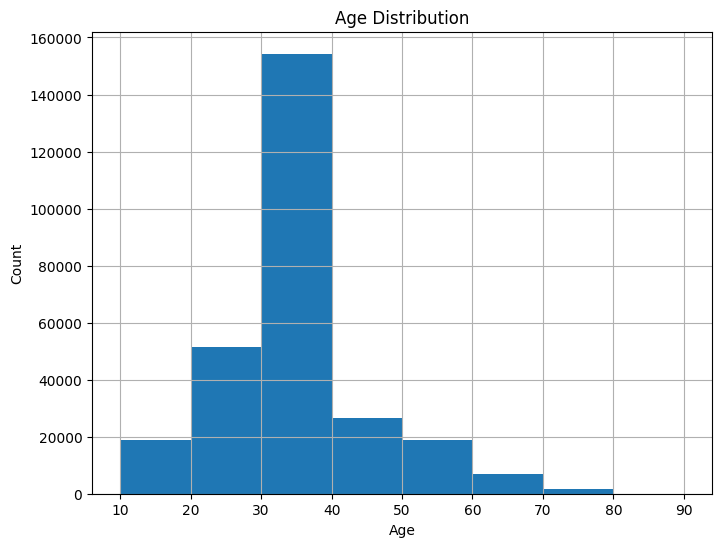

In [147]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No of readers from each city (Top 15)')

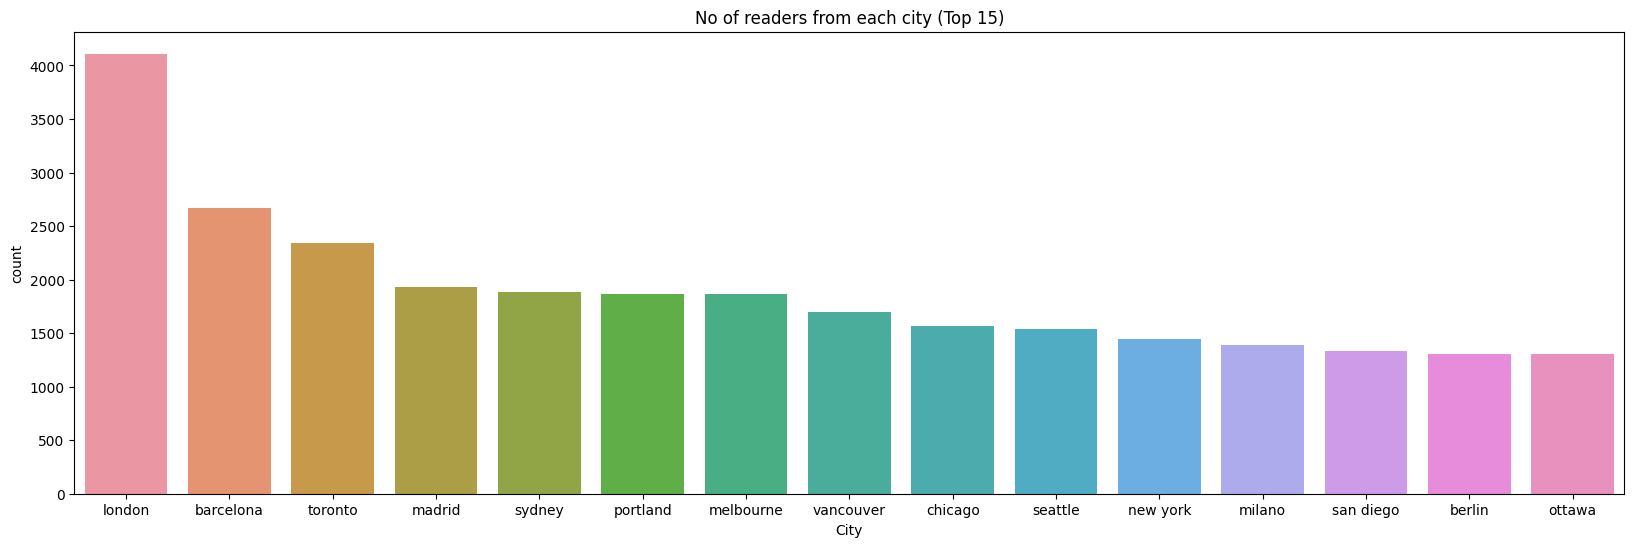

In [148]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

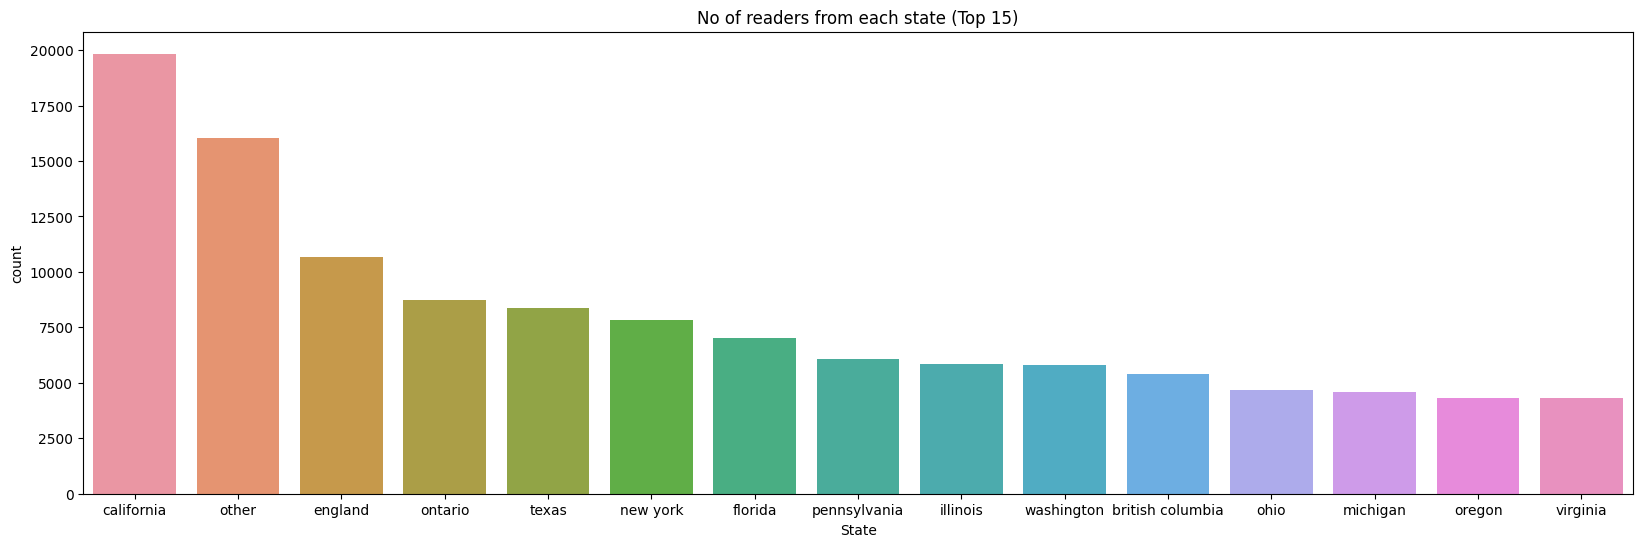

In [149]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

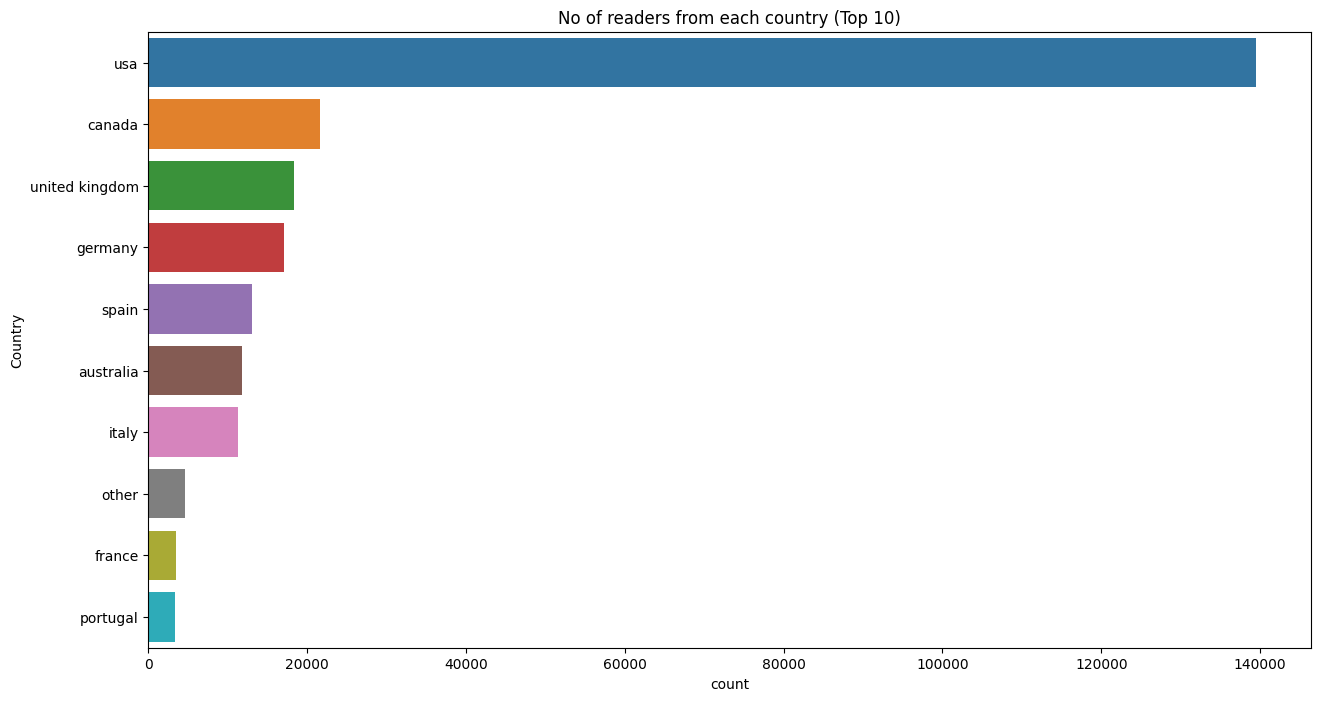

In [150]:
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

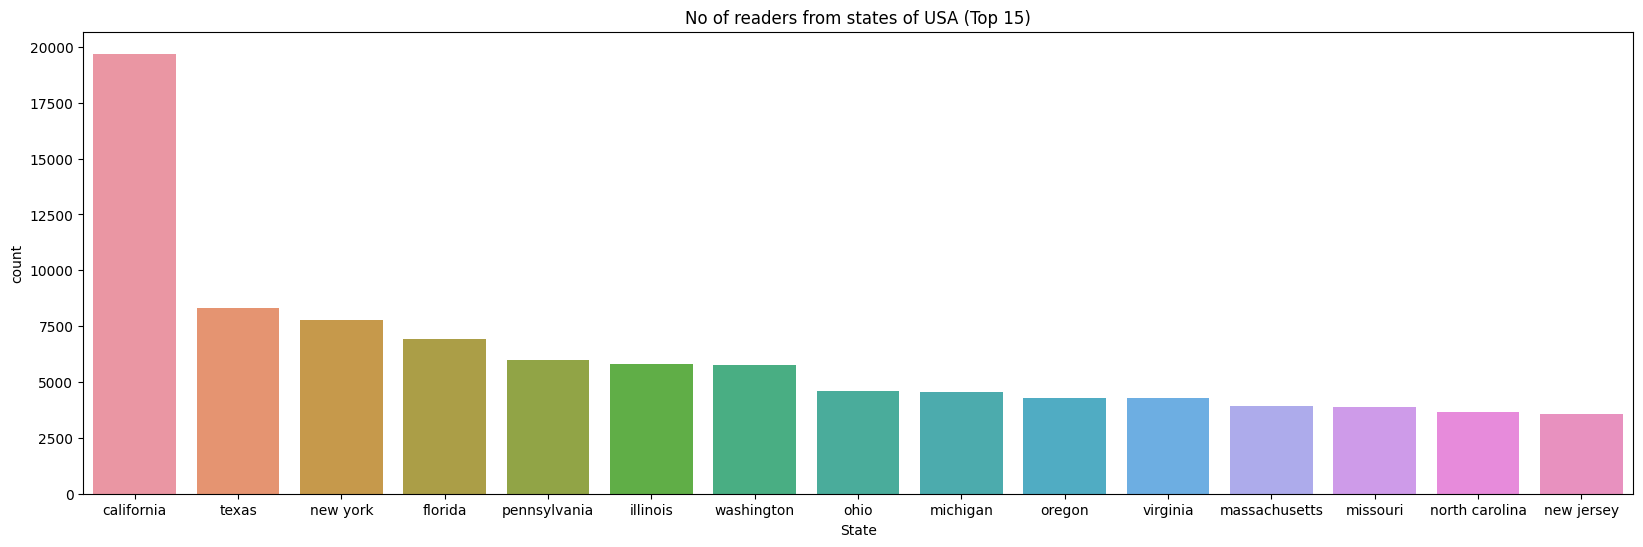

In [151]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

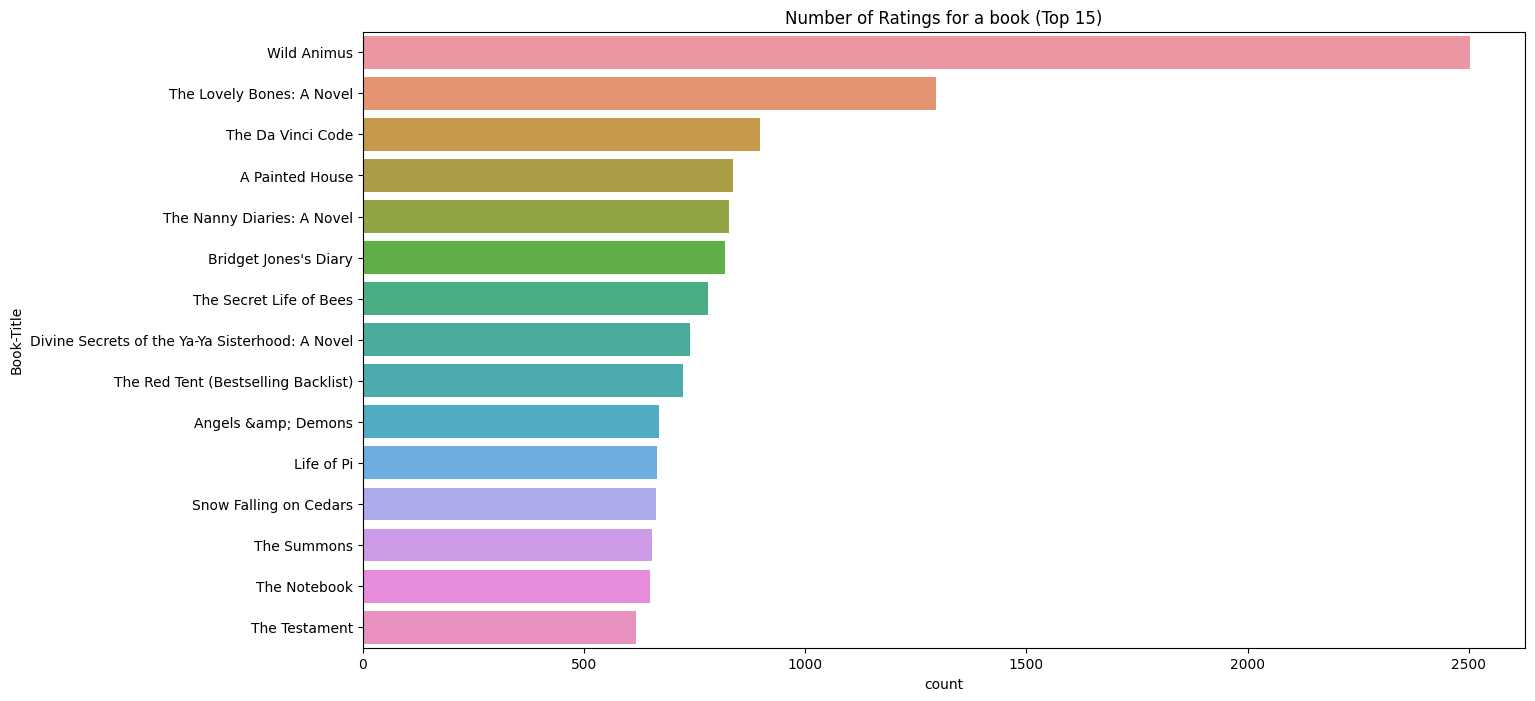

In [152]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

In [153]:
#Phân chia dữ liệu

In [154]:
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import pickle

In [155]:
explicit_ratings = ratings[ratings['Book-Rating'] > 0].copy()
print(f"Số lượng đánh giá tường minh: {len(explicit_ratings)} (rating > 0)")

# 2.2: Phân chia thành các tập train (70%), validation (15%), test (15%)
# Đầu tiên chia thành train + validation và test
train_val_data, test_data = train_test_split(
    explicit_ratings, 
    test_size=0.15, 
    random_state=42, 
    stratify=explicit_ratings['Book-Rating']
)

# Sau đó chia train_val thành train và validation
train_data, val_data = train_test_split(
    train_val_data, 
    test_size=0.1765,  # 15/85 = 0.1765 
    random_state=42, 
    stratify=train_val_data['Book-Rating']
)

print(f"Kích thước tập train: {len(train_data)} ({len(train_data)/len(explicit_ratings)*100:.1f}%)")
print(f"Kích thước tập validation: {len(val_data)} ({len(val_data)/len(explicit_ratings)*100:.1f}%)")
print(f"Kích thước tập test: {len(test_data)} ({len(test_data)/len(explicit_ratings)*100:.1f}%)")


Số lượng đánh giá tường minh: 433669 (rating > 0)
Kích thước tập train: 303556 (70.0%)
Kích thước tập validation: 65062 (15.0%)
Kích thước tập test: 65051 (15.0%)


In [156]:
# 2.3: Tạo ma trận user-item cho collaborative filtering (cách tiếp cận mới để tránh lỗi IndexError)
print("Tạo ma trận user-item dạng thưa...")

# Tạo ánh xạ từ User-ID và ISBN sang indices nhỏ hơn
user_ids = train_data['User-ID'].unique()
isbn_ids = train_data['ISBN'].unique()

user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
isbn_to_idx = {isbn: idx for idx, isbn in enumerate(isbn_ids)}

# Chuyển đổi ID thành indices
row_indices = [user_to_idx[user] for user in train_data['User-ID']]
col_indices = [isbn_to_idx[isbn] for isbn in train_data['ISBN']]
data_values = train_data['Book-Rating'].values

# Tạo ma trận thưa
n_users = len(user_ids)
n_items = len(isbn_ids)
train_sparse_matrix = csr_matrix(
    (data_values, (row_indices, col_indices)), 
    shape=(n_users, n_items)
)

print(f"Kích thước ma trận: {train_sparse_matrix.shape}")
print(f"Số phần tử khác 0: {train_sparse_matrix.count_nonzero()}")
print(f"Tỷ lệ sparsity: {(1 - train_sparse_matrix.count_nonzero()/(n_users*n_items))*100:.4f}%")

Tạo ma trận user-item dạng thưa...
Kích thước ma trận: (63261, 144483)
Số phần tử khác 0: 303555
Tỷ lệ sparsity: 99.9967%


In [157]:
#TỐI ƯU HÓA HYPERPARAMETER

In [158]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import time
import random
from joblib import Parallel, delayed

print("Tối ưu hóa tham số cho KNN Collaborative Filtering (phiên bản nhanh)...")

# 1. Áp dụng popularity threshold để giảm kích thước dữ liệu
def apply_popularity_threshold(ratings_df, threshold=10):
    """Lọc ratings dựa trên popularity threshold"""
    start_time = time.time()
    print(f"Áp dụng ngưỡng phổ biến (popularity threshold): {threshold}")
    
    # Đếm số ratings cho mỗi sách
    book_counts = ratings_df['ISBN'].value_counts()
    popular_books = book_counts[book_counts >= threshold].index
    
    # Lọc ratings
    filtered_df = ratings_df[ratings_df['ISBN'].isin(popular_books)]
    
    print(f"Số sách ban đầu: {len(book_counts)}")
    print(f"Số sách sau khi lọc: {len(popular_books)}")
    print(f"Giảm {(1 - len(popular_books)/len(book_counts))*100:.2f}% số lượng sách")
    
    print(f"Số ratings ban đầu: {len(ratings_df)}")
    print(f"Số ratings sau khi lọc: {len(filtered_df)}")
    print(f"Giữ lại {len(filtered_df)/len(ratings_df)*100:.2f}% ratings")
    
    print(f"Thời gian: {time.time() - start_time:.2f} giây")
    
    return filtered_df

# Áp dụng ngưỡng phổ biến
filtered_ratings = apply_popularity_threshold(ratings, threshold=20)
explicit_ratings = filtered_ratings[filtered_ratings['Book-Rating'] > 0].copy()


Tối ưu hóa tham số cho KNN Collaborative Filtering (phiên bản nhanh)...
Áp dụng ngưỡng phổ biến (popularity threshold): 20
Số sách ban đầu: 339899
Số sách sau khi lọc: 7497
Giảm 97.79% số lượng sách
Số ratings ban đầu: 1149774
Số ratings sau khi lọc: 394449
Giữ lại 34.31% ratings
Thời gian: 0.55 giây


In [159]:
# 2. Hàm đánh giá RMSE tối ưu (nhanh hơn)
def evaluate_rmse_fast(model, data, user_index, isbn_index, max_samples=500):
    """Đánh giá model với RMSE - phiên bản nhanh hơn"""
    y_true = []
    y_pred = []
    
    # Lấy mẫu ngẫu nhiên từ tập dữ liệu để đánh giá nhanh hơn
    if len(data) > max_samples:
        data_sample = data.sample(max_samples, random_state=42)
    else:
        data_sample = data
    
    for _, row in data_sample.iterrows():
        user_id = row['User-ID']
        isbn = row['ISBN']
        rating = row['Book-Rating']
        
        # Kiểm tra nếu user và ISBN có trong mô hình
        if user_id in user_index and isbn in isbn_index:
            user_idx = user_index[user_id]
            item_idx = isbn_index[isbn]
            
            try:
                # Dự đoán rating
                pred_rating = model.predict(user_idx, item_idx)
                
                y_true.append(rating)
                y_pred.append(pred_rating)
            except Exception as e:
                # Bỏ qua lỗi và tiếp tục
                continue
    
    # Tính RMSE nếu có dự đoán
    if len(y_true) > 0:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return rmse
    else:
        return float('inf')


In [160]:
# 3. Tạo và chuẩn bị dữ liệu cho train_sparse_matrix 
def create_user_item_matrix(ratings_df):
    """Tạo ma trận user-item từ dataframe ratings"""
    # Map user và item IDs sang indices
    user_ids = list(ratings_df['User-ID'].unique())
    isbn_ids = list(ratings_df['ISBN'].unique())
    
    user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
    isbn_to_idx = {bid: i for i, bid in enumerate(isbn_ids)}
    
    # Tạo sparse matrix
    from scipy.sparse import csr_matrix
    
    row_indices = [user_to_idx[uid] for uid in ratings_df['User-ID']]
    col_indices = [isbn_to_idx[bid] for bid in ratings_df['ISBN']]
    data_values = ratings_df['Book-Rating'].values
    
    sparse_matrix = csr_matrix((data_values, (row_indices, col_indices)), 
                              shape=(len(user_ids), len(isbn_ids)))
    
    return sparse_matrix, user_to_idx, isbn_to_idx, user_ids, isbn_ids

# Chia dữ liệu train/test
from sklearn.model_selection import train_test_split

# Chia tập dữ liệu
train_data, test_data = train_test_split(
    explicit_ratings, 
    test_size=0.2, 
    random_state=42,
    stratify=explicit_ratings['Book-Rating']
)

# Chia tập train thành train và validation
train_data, val_data = train_test_split(
    train_data, 
    test_size=0.2, 
    random_state=42,
    stratify=train_data['Book-Rating']
)

# Tạo ma trận user-item từ tập train
print("Tạo ma trận user-item...")
start_time = time.time()
train_sparse_matrix, user_to_idx, isbn_to_idx, user_ids, isbn_ids = create_user_item_matrix(train_data)
print(f"Kích thước ma trận: {train_sparse_matrix.shape}")
print(f"Độ thưa: {1.0 - train_sparse_matrix.nnz / (train_sparse_matrix.shape[0] * train_sparse_matrix.shape[1]):.6f}")
print(f"Thời gian: {time.time() - start_time:.2f} giây")

Tạo ma trận user-item...
Kích thước ma trận: (31837, 7478)
Độ thưa: 0.999586
Thời gian: 0.11 giây


In [161]:
# 4. RandomizedSearchCV thay vì grid search đầy đủ
def optimize_knn_params(k_values=[5, 10, 20, 30], 
                        metric_values=['cosine', 'euclidean'], 
                        algorithm_values=['brute', 'ball_tree'], 
                        n_trials=10):
    """Tối ưu hóa hyperparameter cho KNN nhanh hơn với random search"""
    print("Bắt đầu tối ưu hyperparameter...")
    
    # Tạo danh sách các tổ hợp hợp lệ
    valid_combinations = []
    for k in k_values:
        for metric in metric_values:
            for algorithm in algorithm_values:
                # Bỏ qua kết hợp không hợp lệ
                if metric == 'cosine' and algorithm == 'ball_tree':
                    continue
                valid_combinations.append((k, metric, algorithm))
    
    # Nếu số lượng thử nghiệm nhỏ hơn số tổ hợp hợp lệ, chọn ngẫu nhiên
    if n_trials < len(valid_combinations):
        print(f"Chọn ngẫu nhiên {n_trials} tổ hợp từ {len(valid_combinations)} tổ hợp hợp lệ")
        random.seed(42)
        param_combinations = random.sample(valid_combinations, n_trials)
    else:
        print(f"Thử tất cả {len(valid_combinations)} tổ hợp hợp lệ")
        param_combinations = valid_combinations
    
    # Khởi tạo kết quả
    best_rmse = float('inf')
    best_params = {}
    results = []
    
    # Lấy mẫu validation để đánh giá nhanh hơn
    val_sample = val_data.sample(min(300, len(val_data)), random_state=42)
    
    # Hàm để đánh giá một tổ hợp tham số
    def evaluate_params(k, metric, algorithm):
        start_time = time.time()
        print(f"Thử nghiệm với k={k}, metric={metric}, algorithm={algorithm}")
        
        try:
            # Khởi tạo mô hình KNN
            model = NearestNeighbors(
                n_neighbors=k,
                metric=metric,
                algorithm=algorithm,
                n_jobs=-1  # Sử dụng tất cả CPU cores
            )
            
            # Huấn luyện mô hình
            model.fit(train_sparse_matrix)
            
            # Tạo recommender
            class KNNRecommender:
                def __init__(self, model, train_data, user_index, isbn_index):
                    self.model = model
                    self.train_data = train_data
                    self.user_index = user_index
                    self.isbn_index = isbn_index
                    self.train_matrix = train_sparse_matrix
                
                def predict(self, user_idx, item_idx):
                    # Lấy vector user
                    user_vector = self.train_matrix[user_idx].toarray().reshape(1, -1)
                    
                    # Tìm k láng giếng gần nhất
                    _, indices = self.model.kneighbors(user_vector)
                    
                    # Lấy rating trung bình cho item từ các láng giềng
                    neighbors_ratings = []
                    for neighbor_idx in indices[0]:
                        if neighbor_idx == user_idx:
                            continue
                        
                        # Kiểm tra xem láng giềng có rate item này không
                        neighbor_rating = self.train_matrix[neighbor_idx, item_idx]
                        if neighbor_rating != 0:  # Nếu láng giềng đã rate item này
                            neighbors_ratings.append(neighbor_rating)
                    
                    # Nếu không có láng giềng nào đánh giá item này
                    if not neighbors_ratings:
                        return self.train_data['Book-Rating'].mean()  # Trả về rating trung bình
                    
                    return np.mean(neighbors_ratings)
            
            recommender = KNNRecommender(model, train_data, user_to_idx, isbn_to_idx)
            
            # Đánh giá RMSE
            rmse = evaluate_rmse_fast(recommender, val_sample, user_to_idx, isbn_to_idx)
            
            elapsed_time = time.time() - start_time
            print(f"RMSE: {rmse:.4f}, Thời gian: {elapsed_time:.2f} giây")
            
            return {
                'k': k,
                'metric': metric,
                'algorithm': algorithm,
                'rmse': rmse,
                'time': elapsed_time
            }
            
        except Exception as e:
            print(f"Lỗi với tham số này: {str(e)}")
            return {
                'k': k,
                'metric': metric,
                'algorithm': algorithm,
                'rmse': float('inf'),
                'time': 0
            }
    
    # Đánh giá song song các tổ hợp tham số
    print(f"Đánh giá {len(param_combinations)} tổ hợp tham số...")
    
    # Option 1: Đánh giá tuần tự
    for k, metric, algorithm in param_combinations:
        result = evaluate_params(k, metric, algorithm)
        results.append(result)
        
        # Cập nhật tham số tốt nhất
        if result['rmse'] < best_rmse:
            best_rmse = result['rmse']
            best_params = {
                'k': result['k'],
                'metric': result['metric'],
                'algorithm': result['algorithm']
            }
            print(f"Tìm thấy tham số tốt hơn: {best_params} với RMSE: {best_rmse:.4f}")
    
    # Hiển thị kết quả dạng bảng
    results_df = pd.DataFrame(results)
    print("\nKết quả đánh giá tham số:")
    print(results_df.sort_values('rmse'))
    
    print(f"\nTham số tốt nhất cho KNN: {best_params} với RMSE: {best_rmse:.4f}")
    
    return best_params, best_rmse, results_df

In [162]:
# 5. Thực hiện tối ưu 
# Đối với một số người dùng máy yếu, giảm số tổ hợp xuống 
k_values = [5, 10, 15, 20]  # Bỏ k=30 để giảm số lần thử
metric_values = ['cosine', 'euclidean']
algorithm_values = ['brute', 'ball_tree']

# Rút gọn số lượng thử nghiệm xuống 6
best_params, best_rmse, results_df = optimize_knn_params(
    k_values=k_values,
    metric_values=metric_values,
    algorithm_values=algorithm_values,
    n_trials=6  # Chỉ chạy 6 tổ hợp ngẫu nhiên thay vì tất cả
)


Bắt đầu tối ưu hyperparameter...
Chọn ngẫu nhiên 6 tổ hợp từ 12 tổ hợp hợp lệ
Đánh giá 6 tổ hợp tham số...
Thử nghiệm với k=20, metric=euclidean, algorithm=brute
RMSE: 1.7715, Thời gian: 7.11 giây
Tìm thấy tham số tốt hơn: {'k': 20, 'metric': 'euclidean', 'algorithm': 'brute'} với RMSE: 1.7715
Thử nghiệm với k=5, metric=euclidean, algorithm=brute
RMSE: 1.7710, Thời gian: 6.57 giây
Tìm thấy tham số tốt hơn: {'k': 5, 'metric': 'euclidean', 'algorithm': 'brute'} với RMSE: 1.7710
Thử nghiệm với k=5, metric=cosine, algorithm=brute
RMSE: 1.7917, Thời gian: 6.34 giây
Thử nghiệm với k=10, metric=euclidean, algorithm=brute
RMSE: 1.7710, Thời gian: 7.17 giây
Thử nghiệm với k=10, metric=cosine, algorithm=brute
RMSE: 1.7918, Thời gian: 6.63 giây
Thử nghiệm với k=20, metric=euclidean, algorithm=ball_tree
RMSE: 1.7715, Thời gian: 7.44 giây

Kết quả đánh giá tham số:
    k     metric  algorithm      rmse      time
1  5   euclidean  brute      1.771001  6.572517
3  10  euclidean  brute      1.771001  

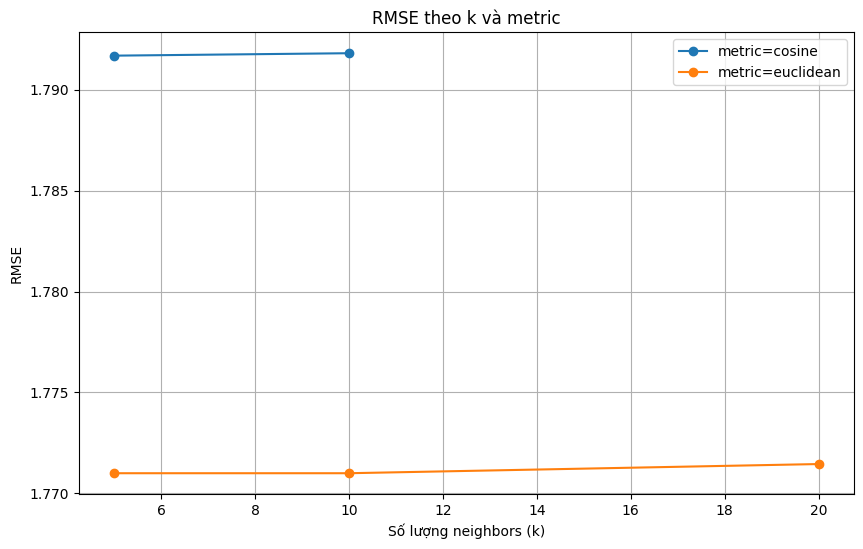

In [163]:
# 6. Biểu diễn kết quả
import matplotlib.pyplot as plt

# Vẽ biểu đồ RMSE theo k và metric
plt.figure(figsize=(10, 6))
for metric in metric_values:
    # Lọc kết quả theo metric
    metric_results = results_df[results_df['metric'] == metric]
    if len(metric_results) > 0:
        # Nhóm theo k và tính RMSE trung bình
        k_rmse = metric_results.groupby('k')['rmse'].mean().reset_index()
        plt.plot(k_rmse['k'], k_rmse['rmse'], marker='o', label=f'metric={metric}')

plt.title('RMSE theo k và metric')
plt.xlabel('Số lượng neighbors (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig('knn_hyperparameter_optimization.png')

In [164]:
# 7. Khởi tạo mô hình với tham số tốt nhất
print("\nKhởi tạo mô hình KNN với tham số tốt nhất...")
best_knn_model = NearestNeighbors(
    n_neighbors=best_params['k'],
    metric=best_params['metric'],
    algorithm=best_params['algorithm'],
    n_jobs=-1  # Sử dụng đa nhân
)
best_knn_model.fit(train_sparse_matrix)


Khởi tạo mô hình KNN với tham số tốt nhất...


NearestNeighbors(algorithm='brute', metric='euclidean', n_jobs=-1)

In [165]:
# 8. Tạo recommender từ mô hình tốt nhất
class KNNRecommender:
    def __init__(self, model, train_data, user_index, isbn_index):
        self.model = model
        self.train_data = train_data
        self.user_index = user_index 
        self.isbn_index = isbn_index
        self.train_matrix = train_sparse_matrix
    
    def predict(self, user_idx, item_idx):
        # Lấy vector user
        user_vector = self.train_matrix[user_idx].toarray().reshape(1, -1)
        
        # Tìm k láng giếng gần nhất
        _, indices = self.model.kneighbors(user_vector)
        
        # Lấy rating trung bình cho item từ các láng giềng
        neighbors_ratings = []
        for neighbor_idx in indices[0]:
            if neighbor_idx == user_idx:
                continue
            
            # Kiểm tra xem láng giềng có rate item này không
            neighbor_rating = self.train_matrix[neighbor_idx, item_idx]
            if neighbor_rating != 0:  # Nếu láng giềng đã rate item này
                neighbors_ratings.append(neighbor_rating)
        
        # Nếu không có láng giềng nào đánh giá item này
        if not neighbors_ratings:
            return self.train_data['Book-Rating'].mean()  # Trả về rating trung bình
        
        return np.mean(neighbors_ratings)
    
    def recommend(self, user_id, k=5, exclude_rated=True):
        """Gợi ý k sách cho một user"""
        if user_id not in self.user_index:
            # Trả về sách phổ biến nếu user không có trong tập huấn luyện
            return []
        
        user_idx = self.user_index[user_id]
        user_vector = self.train_matrix[user_idx].toarray().reshape(1, -1)
        
        # Lấy sách đã đọc của user
        rated_items = self.train_data[self.train_data['User-ID'] == user_id]['ISBN'].unique()
        
        # Tìm k láng giếng gần nhất
        _, indices = self.model.kneighbors(user_vector)
        
        # Tìm các items được láng giềng đánh giá cao
        items_score = {}
        for neighbor_idx in indices[0]:
            if neighbor_idx == user_idx:
                continue
            
            # Lấy ratings của láng giềng này
            neighbor_vector = self.train_matrix[neighbor_idx].toarray().ravel()
            
            # Các items được láng giềng đánh giá
            rated_indices = np.where(neighbor_vector > 0)[0]
            
            for item_idx in rated_indices:
                item_isbn = list(self.isbn_index.keys())[list(self.isbn_index.values()).index(item_idx)]
                
                # Bỏ qua các items đã được user đánh giá
                if exclude_rated and item_isbn in rated_items:
                    continue
                
                # Tính score dựa trên rating của láng giềng và độ tương tự
                item_score = neighbor_vector[item_idx]
                
                # Cộng dồn score
                if item_isbn not in items_score:
                    items_score[item_isbn] = 0
                items_score[item_isbn] += item_score
        
        # Sắp xếp items theo score
        sorted_items = sorted(items_score.items(), key=lambda x: x[1], reverse=True)
        
        # Trả về top-k items
        return [item[0] for item in sorted_items[:k]]

best_recommender = KNNRecommender(best_knn_model, train_data, user_to_idx, isbn_to_idx)

In [166]:
# 9. Đánh giá trên tập test đầy đủ
print("\nĐánh giá mô hình trên tập test...")
test_rmse = evaluate_rmse_fast(best_recommender, test_data, user_to_idx, isbn_to_idx, max_samples=1000)
print(f"RMSE trên tập test: {test_rmse:.4f}")

# 10. Lưu lại mô hình tốt nhất để sử dụng sau này
import pickle

print("\nLưu mô hình tốt nhất...")


Đánh giá mô hình trên tập test...
RMSE trên tập test: 1.7716

Lưu mô hình tốt nhất...


<h2><b>Recommendation Systems

In [167]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

<h5><b> 1. Popularity Based (Top In whole collection)

In [168]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n).reset_index()
        result = pd.merge(data, books, on='ISBN')
        
        # Chỉ chọn các cột bạn muốn hiển thị
        result = result[['ISBN', 'Book-Rating', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
        
        return result
    return "Invalid number of books entered!!"

In [169]:
print("Top", number, "Popular books are: ")
popularity_based(dataset1, number)

Top 5 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial


<h5><b>2. Popularity Based (Top In a given place)

In [170]:
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [171]:
print("Danh sách các cột trong DataFrame:")
print(data.columns.tolist())

Danh sách các cột trong DataFrame:
['User-ID', 'Age', 'City', 'State', 'Country']


In [172]:
place = input("Enter the name of place: ")
data = search_unique_places(dataset1, place)

if isinstance(data, pd.DataFrame):
    data = popularity_based(data, number)

data

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0971880107,3,Wild Animus,Rich Shapero,2004,Too Far
1,0671047612,2,Skin And Bones,Franklin W. Dixon,2000,Aladdin
2,0486284735,2,Pride and Prejudice (Dover Thrift Editions),Jane Austen,1995,Dover Publications
3,8171670407,2,Inscrutable Americans,Mathur Anurag,1996,South Asia Books
4,0006944035,1,Secret Island / Secret Mountain (Two-in-ones),Enid Blyton,1994,HarperCollins Publishers


<b><h5>3. Books by same author, publisher of given book name

In [173]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [174]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [175]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter y el cÃ¡liz de fuego
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Prisoner of Azkaban (Book 3)


Books by same Publisher:

The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
Book! Book! Book!


<h5><b>4. Books popular Yearly

In [176]:
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
# Reset index để 'ISBN' trở thành cột
data = data.reset_index()
# Sau đó merge theo cột 'ISBN'
data = pd.merge(data, books, on='ISBN')

# Chỉ chọn các cột cần thiết thay vì drop 'Book-Rating'
data = data[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

data = data.drop(indices)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
130308,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp
81468,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900,Graphic Arts Center Pub Co
125518,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901,Fireside
48633,0373226888,Tommy's Mom,Linda O. Johnston,1902,Harlequin
104338,038528120X,CATCH 22,JOSEPH HELLER,1904,Delta
103192,0404089119,Charlotte Bronte and Her Sisters,Clement K. Shorter,1906,Ams Pr
24663,0911662251,Kybalion: A Study of the Hermetic Philosophy of Ancient Egypt and Greece,Three Initiates,1908,Yoga Publication Society
53806,0892760508,New Birth,Kenneth Hagin,1911,Faith Library Publications
5084,0684717603,The GREAT GATSBY (Scribner Classic),F. Scott Fritzgerald,1920,Scribner Paper Fiction
27321,0440745454,HOW TO EAT FRIED WORMS,THOMAS ROCKWELL,1923,Yearling


<b><h5>5. Average Weighted Ratings

In [177]:
def avgRating(newdf, df):
    newdf['Average Rating'] = 0
    for x in range(len(newdf)):
        l = list(df.loc[df['Book-Title'] == newdf['Book-Title'][x]]['Book-Rating'])
        newdf['Average Rating'][x] = sum(l)/len(l)
    return newdf

df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

# df = avgRating(df, dataset1)
# df.to_pickle('weightedData')
df = pd.read_pickle('weightedData')

In [178]:
## C - Mean vote across the whole
C = df['Average Rating'].mean()

## Minimum number of votes required to be in the chart
m = df['Total-Ratings'].quantile(0.90)

In [179]:
def weighted_rating(x, m=m, C=C): 
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average Rating']   #R - Average Rating   
    return (v/(v+m) * R) + (m/(m+v) * C)

In [180]:
df = df.loc[df['Total-Ratings'] >= m]

df['score'] = df.apply(weighted_rating, axis=1)
df = df.sort_values('score', ascending=False)

print("Recommended Books:-\n")
df.head(number)

Recommended Books:-



,Book-Title,Total-Ratings,Average Rating,score
4794,Postmarked Yesteryear: 30 Rare Holiday Postcards,11,10,9.189906
7272,The Sneetches and Other Stories,8,10,9.002961
17,Harry Potter and the Prisoner of Azkaban (Book 3),277,9,8.971768
28,Harry Potter and the Goblet of Fire (Book 4),247,9,8.968407
42,Harry Potter and the Order of the Phoenix (Book 5),211,9,8.963141


<b><h5>6. Collaborative Filtering (User-Item Filtering)

Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources)

In [181]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

User - Item Collaborative Filtering

In [182]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [183]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [184]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [185]:
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
Fried Green Tomatoes at the Whistle Stop Cafe


In [186]:
#Matrix Factorization (SVD)

In [187]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

def create_user_item_matrix(ratings_df):
    """Tạo ma trận user-item từ dataframe ratings"""
    # Convert dữ liệu sang định dạng phù hợp
    ratings_df = ratings_df[['User-ID', 'ISBN', 'Book-Rating']]
    
    # Map user và item IDs sang indices
    user_ids = list(ratings_df['User-ID'].unique())
    isbn_ids = list(ratings_df['ISBN'].unique())
    
    user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
    isbn_to_idx = {bid: i for i, bid in enumerate(isbn_ids)}
    
    # Tạo sparse matrix
    row_indices = [user_to_idx[uid] for uid in ratings_df['User-ID']]
    col_indices = [isbn_to_idx[bid] for bid in ratings_df['ISBN']]
    data_values = ratings_df['Book-Rating'].values
    
    sparse_matrix = csr_matrix((data_values, (row_indices, col_indices)), 
                               shape=(len(user_ids), len(isbn_ids)))
    
    return sparse_matrix, user_to_idx, isbn_to_idx, user_ids, isbn_ids

# Tạo ma trận user-item từ tập train
print("Tạo ma trận user-item...")
sparse_matrix, user_to_idx, isbn_to_idx, user_ids, isbn_ids = create_user_item_matrix(train_data)

print(f"Ma trận ban đầu: {sparse_matrix.shape}")
print(f"Độ thưa: {1.0 - sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]):.6f}")

Tạo ma trận user-item...
Ma trận ban đầu: (31837, 7478)
Độ thưa: 0.999586


In [188]:
# Chọn số lượng nhân tố tiềm ẩn (latent factors)
n_factors = 50

# Định nghĩa hàm popularity_recommendations để xử lý user mới
def popularity_recommendations(user_id, k=5):
    """Đề xuất sách phổ biến nhất cho user mới"""
    # Lấy k sách phổ biến nhất từ dataset1
    popular_books = popularity_based(dataset1, k)
    
    # Kiểm tra nếu kết quả là DataFrame (trường hợp thành công)
    if isinstance(popular_books, pd.DataFrame):
        return popular_books['ISBN'].tolist()
    
    # Trường hợp có lỗi, trả về danh sách rỗng
    print(f"Lỗi khi lấy sách phổ biến: {popular_books}")
    return []

# Khởi tạo và huấn luyện mô hình SVD
print("Huấn luyện mô hình SVD...")
svd = TruncatedSVD(n_components=n_factors, random_state=42)
U = svd.fit_transform(sparse_matrix)
Vt = svd.components_

print(f"Ma trận U: {U.shape}")
print(f"Ma trận Vt: {Vt.shape}")
print(f"Phương sai giải thích được: {svd.explained_variance_ratio_.sum():.4f}")

# Tạo lớp SVD Recommender
class SVDRecommender:
    def __init__(self, U, Vt, user_to_idx, isbn_to_idx, user_ids, isbn_ids):
        self.U = U
        self.Vt = Vt
        self.user_to_idx = user_to_idx
        self.isbn_to_idx = isbn_to_idx
        self.user_ids = user_ids
        self.isbn_ids = isbn_ids
    
    def predict(self, user_id, isbn):
        """Dự đoán rating cho một cặp user-item"""
        if user_id not in self.user_to_idx or isbn not in self.isbn_to_idx:
            return 0  # Default rating nếu user hoặc item không có trong tập huấn luyện
        
        user_idx = self.user_to_idx[user_id]
        item_idx = self.isbn_to_idx[isbn]
        
        # Dự đoán rating = u_i * v_j^T
        prediction = np.dot(self.U[user_idx, :], self.Vt[:, item_idx])
        
        # Giới hạn trong khoảng 0-10
        return max(0, min(10, prediction))
    
    def recommend(self, user_id, k=5, exclude_rated=True):
        """Gợi ý k items cho một user"""
        if user_id not in self.user_to_idx:
            # Nếu là user mới, trả về sách phổ biến
            return popularity_recommendations(user_id, k)
        
        user_idx = self.user_to_idx[user_id]
        user_vector = self.U[user_idx, :]
        
        # Dự đoán rating cho tất cả items
        predictions = user_vector.dot(self.Vt)
        
        # Nếu loại bỏ items đã rated
        if exclude_rated:
            rated_items = train_data[train_data['User-ID'] == user_id]['ISBN'].unique()
            rated_item_indices = [self.isbn_to_idx[isbn] for isbn in rated_items if isbn in self.isbn_to_idx]
            predictions[rated_item_indices] = -1
        
        # Lấy k indices có rating cao nhất
        top_item_indices = np.argsort(predictions)[-k:][::-1]
        
        # Convert indices sang ISBN
        recommended_items = [self.isbn_ids[idx] for idx in top_item_indices]
        
        return recommended_items

# Khởi tạo SVD recommender
svd_recommender = SVDRecommender(U, Vt, user_to_idx, isbn_to_idx, user_ids, isbn_ids)

# Test SVD recommender
test_user = user_ids[0]
recommended_items = svd_recommender.recommend(test_user, k=5)
print(f"\nĐề xuất cho user {test_user}:")
for i, isbn in enumerate(recommended_items):
    book_title = books[books['ISBN'] == isbn]['Book-Title'].values[0] if isbn in books['ISBN'].values else "Unknown"
    print(f"{i+1}. {book_title} (ISBN: {isbn})")

Huấn luyện mô hình SVD...
Ma trận U: (31837, 50)
Ma trận Vt: (50, 7478)
Phương sai giải thích được: 0.1209

Đề xuất cho user 64220:
1. Interview with the Vampire (ISBN: 0345337662)
2. Four To Score (A Stephanie Plum Novel) (ISBN: 0312966970)
3. To Kill a Mockingbird (ISBN: 0446310786)
4. Two for the Dough (ISBN: 0671001795)
5. Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel) (ISBN: 0312976275)


In [189]:
import time
import numpy as np

def evaluate_recommender(recommender_func, test_data, k=5, max_users=500):
    """
    Đánh giá hiệu suất của recommender function không sử dụng tqdm
    """
    precision_sum = 0
    recall_sum = 0
    f1_sum = 0
    ndcg_sum = 0
    user_count = 0
    error_count = 0
    
    # Lấy danh sách user duy nhất và lấy mẫu ngẫu nhiên
    test_users = test_data['User-ID'].unique()
    print(f"Tổng số users trong test data: {len(test_users)}")
    
    if max_users and max_users < len(test_users):
        np.random.seed(42)  # Để kết quả có thể tái tạo
        test_users = np.random.choice(test_users, max_users, replace=False)
        print(f"Đánh giá trên {max_users} users ngẫu nhiên")
    
    start_time = time.time()
    total_users = len(test_users)
    
    # Vòng lặp đánh giá với hiển thị tiến độ đơn giản
    for i, user_id in enumerate(test_users):
        # Hiển thị tiến độ mỗi 10 users hoặc khi hoàn thành
        if i % 10 == 0 or i == total_users - 1:
            progress = (i + 1) / total_users * 100
            elapsed = time.time() - start_time
            est_total = elapsed / (i + 1) * total_users if i > 0 else 0
            print(f"Tiến độ: {i+1}/{total_users} ({progress:.1f}%) - Thời gian: {elapsed:.1f}s / ~{est_total:.1f}s", end="\r")
        
        user_test_data = test_data[test_data['User-ID'] == user_id]
        actual_items = set(user_test_data['ISBN'])
        
        if len(actual_items) == 0:
            continue
            
        # Xử lý lỗi
        try:
            recommended_items = recommender_func(user_id, k)
            if recommended_items is None or len(recommended_items) == 0:
                continue
            recommended_items = set(recommended_items)
        except Exception as e:
            error_count += 1
            if error_count <= 3:  # Chỉ hiển thị 3 lỗi đầu tiên
                print(f"\nLỗi với user {user_id}: {str(e)}")
            continue
        
        # Tính metrics (giữ nguyên phần này)
        relevant = len(actual_items.intersection(recommended_items))
        precision = relevant / min(len(recommended_items), k) if len(recommended_items) > 0 else 0
        recall = relevant / len(actual_items) if len(actual_items) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Tính NDCG
        dcg = 0
        for i, item in enumerate(recommended_items):
            if item in actual_items:
                dcg += 1 / np.log2(i + 2)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual_items), k)))
        ndcg = dcg / idcg if idcg > 0 else 0
        
        precision_sum += precision
        recall_sum += recall
        f1_sum += f1
        ndcg_sum += ndcg
        user_count += 1
    
    # In một dòng mới sau khi kết thúc hiển thị tiến độ
    print("")
    
    # Thống kê
    elapsed_time = time.time() - start_time
    print(f"Đánh giá hoàn thành trong {elapsed_time:.2f} giây ({elapsed_time/60:.2f} phút)")
    print(f"Số lượng users đã đánh giá thành công: {user_count}/{len(test_users)}")
    
    # Tính giá trị trung bình
    if user_count > 0:
        return {
            'precision': precision_sum / user_count,
            'recall': recall_sum / user_count,
            'f1': f1_sum / user_count,
            'ndcg': ndcg_sum / user_count
        }
    else:
        print("CẢNH BÁO: Không có user nào được đánh giá thành công!")
        return {
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'ndcg': 0
        }

In [190]:
# Cách nhanh hơn sử dụng nunique()

num_users = test_data['User-ID'].nunique()
print(f"Số lượng user trong test_data: {num_users}")

Số lượng user trong test_data: 14964


In [191]:
# Thêm SVD Recommender vào danh sách đánh giá
def svd_recommendations(user_id, k=5):
    return svd_recommender.recommend(user_id, k)

models = {}

models['Matrix Factorization (SVD)'] = svd_recommendations

results = {}
# Đánh giá SVD Recommender
print("Đánh giá Matrix Factorization (SVD)...")
metrics = evaluate_recommender(svd_recommendations, test_data, k=5)
results['Matrix Factorization (SVD)'] = metrics

print(f"  - Precision@5: {metrics['precision']:.4f}")
print(f"  - Recall@5: {metrics['recall']:.4f}")
print(f"  - F1@5: {metrics['f1']:.4f}")
print(f"  - NDCG@5: {metrics['ndcg']:.4f}")

# Cập nhật bảng so sánh
results_df = pd.DataFrame(results).T
print("\nSo sánh hiệu suất các mô hình (bao gồm SVD):")
print(results_df)

Đánh giá Matrix Factorization (SVD)...
Tổng số users trong test data: 14964
Đánh giá trên 500 users ngẫu nhiên
Tiến độ: 500/500 (100.0%) - Thời gian: 79.0s / ~79.0s
Đánh giá hoàn thành trong 79.02 giây (1.32 phút)
Số lượng users đã đánh giá thành công: 500/500
  - Precision@5: 0.0076
  - Recall@5: 0.0233
  - F1@5: 0.0098
  - NDCG@5: 0.0167

So sánh hiệu suất các mô hình (bao gồm SVD):
                                  f1      ndcg  precision    recall
Matrix Factorization (SVD)  0.009826  0.016654  0.0076     0.023311


In [192]:
# Giải quyết cold-start problem

In [193]:
# Phương pháp xử lý cold-start cho user mới

def get_user_demographics(user_id):
    """Lấy thông tin nhân khẩu học của user"""
    # Trong trường hợp thực tế, ta có thể có thông tin như tuổi, giới tính, vị trí
    # Ở đây sẽ lấy thông tin từ dataset users
    user_data = users[users['User-ID'] == user_id]
    if len(user_data) == 0:
        return {'Age': None, 'City': None, 'State': None, 'Country': None}
    
    return {
        'Age': user_data['Age'].values[0],
        'City': user_data['City'].values[0],
        'State': user_data['State'].values[0],
        'Country': user_data['Country'].values[0]
    }

def recommend_for_new_user(user_id, k=5):
    """Gợi ý sách cho user mới dựa trên nhân khẩu học"""
    demographics = get_user_demographics(user_id)
    
    # Nếu không có thông tin demographic, dùng popularity-based
    if demographics['Age'] is None:
        return popularity_recommendations(user_id, k)
    
    # Tìm các user tương tự về nhân khẩu học
    similar_users = users.copy()
    
    # Lọc theo độ tuổi tương tự (±5 tuổi)
    if pd.notna(demographics['Age']):
        similar_users = similar_users[(similar_users['Age'] >= demographics['Age'] - 5) & 
                                      (similar_users['Age'] <= demographics['Age'] + 5)]
    
    # Lọc theo khu vực địa lý
    for feature in ['Country', 'State', 'City']:
        if pd.notna(demographics[feature]) and len(similar_users) > 10:
            temp = similar_users[similar_users[feature] == demographics[feature]]
            if len(temp) > 0:
                similar_users = temp
    
    # Lấy sách được đánh giá cao bởi các user tương tự
    similar_user_ids = similar_users['User-ID'].unique()
    if len(similar_user_ids) == 0:
        return popularity_recommendations(user_id, k)
    
    # Lấy ratings từ users tương tự
    similar_ratings = train_data[train_data['User-ID'].isin(similar_user_ids)]
    
    # Nhóm theo ISBN và tính rating trung bình
    book_ratings = similar_ratings.groupby('ISBN')['Book-Rating'].agg(['mean', 'count']).reset_index()
    
    # Lọc các sách có ít nhất 5 đánh giá
    book_ratings = book_ratings[book_ratings['count'] >= 5]
    
    # Sắp xếp theo rating trung bình giảm dần
    book_ratings = book_ratings.sort_values('mean', ascending=False)
    
    # Trả về k sách hàng đầu
    top_books = book_ratings.head(k)['ISBN'].tolist()
    
    return top_books

In [194]:
def extract_book_features(isbn):
    """Trích xuất đặc trưng của sách"""
    book_data = books[books['ISBN'] == isbn]
    if len(book_data) == 0:
        return None
    
    features = {
        'Title': book_data['Book-Title'].values[0],
        'Author': book_data['Book-Author'].values[0],
        'Year': book_data['Year-Of-Publication'].values[0],
        'Publisher': book_data['Publisher'].values[0],
        'Title-Length': len(str(book_data['Book-Title'].values[0]))
    }
    
    return features

def find_similar_books(isbn, k=5):
    """Tìm các sách tương tự dựa trên đặc trưng"""
    # Lấy đặc trưng của sách
    book_features = extract_book_features(isbn)
    if book_features is None:
        return []
    
    # Lọc sách cùng tác giả
    same_author_books = books[books['Book-Author'] == book_features['Author']]
    
    # Nếu có đủ sách cùng tác giả
    if len(same_author_books) >= k:
        # Ưu tiên sách gần năm xuất bản
        same_author_books['Year_Diff'] = abs(same_author_books['Year-Of-Publication'] - book_features['Year'])
        same_author_books = same_author_books.sort_values('Year_Diff')
        similar_books = same_author_books[same_author_books['ISBN'] != isbn].head(k)['ISBN'].tolist()
        
        if len(similar_books) >= k:
            return similar_books
    
    # Nếu không đủ, tìm sách cùng nhà xuất bản và gần năm xuất bản
    same_publisher_books = books[books['Publisher'] == book_features['Publisher']]
    same_publisher_books['Year_Diff'] = abs(same_publisher_books['Year-Of-Publication'] - book_features['Year'])
    same_publisher_books = same_publisher_books.sort_values('Year_Diff')
    
    # Loại bỏ các sách đã có trong danh sách tương tự
    if 'similar_books' in locals():
        same_publisher_books = same_publisher_books[~same_publisher_books['ISBN'].isin(similar_books)]
    
    # Thêm vào danh sách tương tự
    publisher_similar = same_publisher_books[same_publisher_books['ISBN'] != isbn].head(k)['ISBN'].tolist()
    
    if 'similar_books' in locals():
        similar_books.extend(publisher_similar)
        similar_books = similar_books[:k]
    else:
        similar_books = publisher_similar
    
    # Nếu vẫn không đủ, thêm sách có năm xuất bản gần nhất
    if len(similar_books) < k:
        all_books = books.copy()
        
        # Loại bỏ các sách đã có trong danh sách tương tự
        all_books = all_books[~all_books['ISBN'].isin(similar_books)]
        all_books = all_books[all_books['ISBN'] != isbn]
        
        all_books['Year_Diff'] = abs(all_books['Year-Of-Publication'] - book_features['Year'])
        year_similar = all_books.sort_values('Year_Diff').head(k - len(similar_books))['ISBN'].tolist()
        
        similar_books.extend(year_similar)
    
    return similar_books[:k]

def recommend_for_new_book(isbn, k=5):
    """Gợi ý sách tương tự với sách mới"""
    similar_books = find_similar_books(isbn, k)
    return similar_books

# Kiểm tra với một sách mới
new_book_isbn = books['ISBN'].iloc[0]  # Lấy một ISBN bất kỳ để thử nghiệm
print(f"Sách gốc: {books[books['ISBN'] == new_book_isbn]['Book-Title'].values[0]}")
print("Sách tương tự:")
similar_books = recommend_for_new_book(new_book_isbn, k=5)
for i, isbn in enumerate(similar_books):
    title = books[books['ISBN'] == isbn]['Book-Title'].values[0]
    author = books[books['ISBN'] == isbn]['Book-Author'].values[0]
    print(f"{i+1}. {title} by {author}")

Sách gốc: Classical Mythology
Sách tương tự:
1. The Odd Women (Oxford World's Classics) by George Gissing
2. Stop the Train by Geraldine McCaughrean
3. The Oxford History of Byzantium by Cyril A. Mango
4. The Oxford Book of Sonnets (Oxford Books of Verse) by John Fuller
5. Pocket Oxford English Dictionary by Catherine Soanes


In [195]:
def smart_recommend(user_id, isbn=None, k=5):
    """Hệ thống gợi ý thông minh xử lý cả cold-start"""
    # Kiểm tra xem user có trong tập huấn luyện không
    is_new_user = user_id not in user_to_idx
    
    # Nếu không có ISBN cụ thể, gợi ý sách cho user
    if isbn is None:
        if is_new_user:
            # Xử lý user mới
            return recommend_for_new_user(user_id, k)
        else:
            # User đã biết, dùng collaborative filtering
            return svd_recommendations(user_id, k)
    else:
        # Kiểm tra xem sách có trong tập huấn luyện không
        is_new_book = isbn not in isbn_to_idx
        
        if is_new_book:
            # Xử lý sách mới
            return recommend_for_new_book(isbn, k)
        else:
            # Sách đã biết, tìm sách tương tự
            # Có thể dùng content-based hoặc item-based collaborative filtering
            return find_similar_books(isbn, k)

# Test hệ thống gợi ý thông minh
# Giả sử có một user mới
new_user_id = max(user_ids) + 1
print(f"Gợi ý cho user mới (ID: {new_user_id}):")
recommendations = smart_recommend(new_user_id, k=5)
for i, isbn in enumerate(recommendations):
    if isbn in books['ISBN'].values:
        title = books[books['ISBN'] == isbn]['Book-Title'].values[0]
        print(f"{i+1}. {title}")
    else:
        print(f"{i+1}. Unknown book (ISBN: {isbn})")

# Giả sử có một sách mới
new_book_isbn = "NewISBN123"  # ISBN không có trong tập huấn luyện
# Trong thực tế, ta cần thêm thông tin của sách mới vào DataFrame books
print(f"\nGợi ý sách tương tự với sách mới (ISBN: {new_book_isbn}):")
# Do sách này không thực sự tồn tại, ta sẽ dùng một sách có thật để thử nghiệm
existing_isbn = books['ISBN'].iloc[0]
recommendations = smart_recommend(None, existing_isbn, k=5)
for i, isbn in enumerate(recommendations):
    title = books[books['ISBN'] == isbn]['Book-Title'].values[0]
    print(f"{i+1}. {title}")

Gợi ý cho user mới (ID: 278855):

Gợi ý sách tương tự với sách mới (ISBN: NewISBN123):
1. The Odd Women (Oxford World's Classics)
2. Stop the Train
3. The Oxford History of Byzantium
4. The Oxford Book of Sonnets (Oxford Books of Verse)
5. Pocket Oxford English Dictionary


<b><h5>7. Correlation Based

In [196]:
popularity_threshold = 50

user_count = dataset1['User-ID'].value_counts()
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [197]:
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


In [198]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Title-Length,Decade
0,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,48,2000
1,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic,49,2000
2,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,44,2000
3,0804115613,Fried Green Tomatoes at the Whistle Stop Cafe,Fannie Flagg,2000,Ballantine Books,45,2000
4,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks,44,2000


<h5><b>8. Nearest Neighbours Based

In [199]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [200]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 


Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)


<h5><b>9. Content Based

In [201]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44652, 8)

In [202]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(44652, 1112)

In [203]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(44652, 44652)

In [204]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:



Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Order of the Phoenix (Book 5)


<b><h5>10. Hybrid Approach (Content+Collaborative) Using percentile

In [205]:
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
print(bookName)
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Recommended Books:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Order of the Phoenix (Book 5)


In [206]:
#Neural Collaborative Filtering (NCF)

In [207]:
#Neural Collaborative Filtering (NCF)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [208]:
# Chuẩn bị dữ liệu cho NCF
print("Chuẩn bị dữ liệu cho Neural Collaborative Filtering...")

# Lọc ratings với ratings > 0 để tập trung vào ratings tích cực
ncf_ratings = ratings[ratings['Book-Rating'] > 0].copy()

# Chuẩn hóa ratings để đưa về khoảng 0-1
max_rating = 10
ncf_ratings['Book-Rating'] = ncf_ratings['Book-Rating'] / max_rating

# Map user và item IDs sang indices phù hợp với Embedding
user_ids = list(ncf_ratings['User-ID'].unique())
isbn_ids = list(ncf_ratings['ISBN'].unique())

user_id_map = {uid: i for i, uid in enumerate(user_ids)}
isbn_id_map = {iid: i for i, iid in enumerate(isbn_ids)}

ncf_ratings['user_idx'] = ncf_ratings['User-ID'].map(user_id_map)
ncf_ratings['isbn_idx'] = ncf_ratings['ISBN'].map(isbn_id_map)

# Chia dữ liệu thành train và validation
train_data, val_data = train_test_split(ncf_ratings, test_size=0.2, random_state=42)

print(f"Số lượng users: {len(user_ids)}")
print(f"Số lượng books: {len(isbn_ids)}")
print(f"Số lượng ratings: {len(ncf_ratings)}")
print(f"Tập huấn luyện: {len(train_data)} mẫu")
print(f"Tập validation: {len(val_data)} mẫu")

Chuẩn bị dữ liệu cho Neural Collaborative Filtering...
Số lượng users: 77805
Số lượng books: 185680
Số lượng ratings: 433669
Tập huấn luyện: 346935 mẫu
Tập validation: 86734 mẫu


In [209]:
# Xây dựng mô hình NCF
print("Xây dựng mô hình Neural Collaborative Filtering...")

# Tham số mô hình
embedding_size = 32
layers = [64, 32, 16, 8]
reg = l2(1e-4)
learning_rate = 0.001
batch_size = 256
epochs = 5  # Trong thực tế có thể cần nhiều epochs hơn

# Input layers
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# MLP Embedding layers
user_embedding_mlp = Embedding(input_dim=len(user_ids), output_dim=embedding_size, 
                               embeddings_regularizer=reg, name='user_embedding_mlp')(user_input)
item_embedding_mlp = Embedding(input_dim=len(isbn_ids), output_dim=embedding_size,
                               embeddings_regularizer=reg, name='item_embedding_mlp')(item_input)

# GMF Embedding layers
user_embedding_gmf = Embedding(input_dim=len(user_ids), output_dim=embedding_size, 
                               embeddings_regularizer=reg, name='user_embedding_gmf')(user_input)
item_embedding_gmf = Embedding(input_dim=len(isbn_ids), output_dim=embedding_size,
                               embeddings_regularizer=reg, name='item_embedding_gmf')(item_input)

# MLP part
user_vec_mlp = Flatten()(user_embedding_mlp)
item_vec_mlp = Flatten()(item_embedding_mlp)
concat = Concatenate()([user_vec_mlp, item_vec_mlp])

for i, layer_size in enumerate(layers):
    if i == 0:
        mlp_vector = Dense(layer_size, activation='relu', name=f'layer{i}')(concat)
    else:
        mlp_vector = Dense(layer_size, activation='relu', name=f'layer{i}')(mlp_vector)
    mlp_vector = Dropout(0.2)(mlp_vector)

# GMF part
user_vec_gmf = Flatten()(user_embedding_gmf)
item_vec_gmf = Flatten()(item_embedding_gmf)
gmf_vector = tf.multiply(user_vec_gmf, item_vec_gmf)

# Concatenate GMF and MLP
ncf_vector = Concatenate()([gmf_vector, mlp_vector])

# Output layer
output = Dense(1, activation='sigmoid', name='output')(ncf_vector)

# Build model
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Hiển thị tóm tắt mô hình
model.summary()

Xây dựng mô hình Neural Collaborative Filtering...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding_mlp (Embedding)  (None, 1, 32)       2489760     ['user_input[0][0]']             
                                                                                                  
 item_embedding_mlp (Embedding)  (None, 1, 32)       5941760     ['item_input[0][0]']             
                                           

Huấn luyện mô hình NCF...
Epoch 1/5
1356/1356 [==============================] - 158s 114ms/step - loss: 0.0581 - val_loss: 0.0396
Epoch 2/5
1356/1356 [==============================] - 141s 104ms/step - loss: 0.0418 - val_loss: 0.0401
Epoch 3/5
1356/1356 [==============================] - 138s 102ms/step - loss: 0.0396 - val_loss: 0.0409
Epoch 4/5
1356/1356 [==============================] - 141s 104ms/step - loss: 0.0401 - val_loss: 0.0441
Epoch 5/5
1356/1356 [==============================] - 138s 102ms/step - loss: 0.0432 - val_loss: 0.0511
Mô hình đã được lưu vào ncf_model.h5


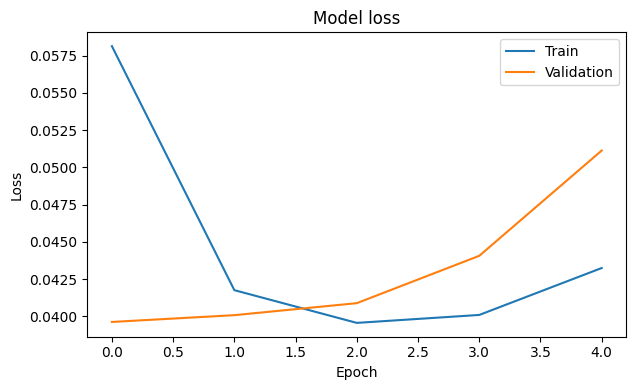

In [210]:
# Huấn luyện mô hình NCF
print("Huấn luyện mô hình NCF...")

# Chuẩn bị dữ liệu huấn luyện
train_users = train_data['user_idx'].values
train_items = train_data['isbn_idx'].values
train_ratings = train_data['Book-Rating'].values

val_users = val_data['user_idx'].values
val_items = val_data['isbn_idx'].values
val_ratings = val_data['Book-Rating'].values

# Huấn luyện mô hình
history = model.fit(
    [train_users, train_items], train_ratings,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=([val_users, val_items], val_ratings)
)

# Lưu mô hình
model.save('ncf_model.h5')
print("Mô hình đã được lưu vào ncf_model.h5")

# Trực quan hóa quá trình huấn luyện
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [211]:
# Lớp NCF Recommender
class NCFRecommender:
    def __init__(self, model, user_id_map, isbn_id_map, user_ids, isbn_ids, max_rating=10):
        self.model = model
        self.user_id_map = user_id_map
        self.isbn_id_map = isbn_id_map
        self.user_ids = user_ids
        self.isbn_ids = isbn_ids
        self.user_idx_to_id = {idx: uid for uid, idx in user_id_map.items()}
        self.isbn_idx_to_id = {idx: iid for iid, idx in isbn_id_map.items()}
        self.max_rating = max_rating
    
    def predict(self, user_id, isbn):
        """Dự đoán rating cho một cặp user-item"""
        if user_id not in self.user_id_map or isbn not in self.isbn_id_map:
            return 0  # Default rating nếu user hoặc item không có trong tập huấn luyện
        
        user_idx = self.user_id_map[user_id]
        item_idx = self.isbn_id_map[isbn]
        
        # Dự đoán
        prediction = self.model.predict([np.array([user_idx]), np.array([item_idx])])[0][0]
        
        # Chuyển đổi lại về thang đo gốc
        prediction = prediction * self.max_rating
        
        # Giới hạn trong khoảng 0-10
        return max(0, min(10, prediction))
    
    def recommend(self, user_id, k=5, exclude_rated=True):
        """Gợi ý k items cho một user"""
        if user_id not in self.user_id_map:
            # Nếu là user mới, trả về sách phổ biến
            return popularity_recommendations(user_id, k)
        
        user_idx = self.user_id_map[user_id]
        
        # Tạo danh sách item để dự đoán
        if exclude_rated:
            rated_items = ratings[ratings['User-ID'] == user_id]['ISBN'].unique()
            candidate_items = [isbn for isbn in self.isbn_ids if isbn not in rated_items]
        else:
            candidate_items = self.isbn_ids
        
        # Giới hạn số lượng items để dự đoán (tăng tốc)
        if len(candidate_items) > 1000:
            candidate_items = np.random.choice(candidate_items, 1000, replace=False)
        
        # Dự đoán ratings cho tất cả items
        predictions = []
        batch_size = 100
        
        for i in range(0, len(candidate_items), batch_size):
            batch_items = candidate_items[i:i+batch_size]
            user_idxs = np.array([user_idx] * len(batch_items))
            item_idxs = np.array([self.isbn_id_map[isbn] for isbn in batch_items])
            
            batch_predictions = self.model.predict([user_idxs, item_idxs]).flatten()
            
            for j, isbn in enumerate(batch_items):
                predictions.append((isbn, batch_predictions[j]))
        
        # Sắp xếp theo dự đoán cao nhất
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Trả về k items có rating cao nhất
        recommended_items = [str(item[0]) for item in predictions[:k]]
        
        return recommended_items
    


# Khởi tạo NCF recommender
ncf_recommender = NCFRecommender(model, user_id_map, isbn_id_map, user_ids, isbn_ids)

# Hàm gợi ý để đánh giá
def ncf_recommendations(user_id, k=5):
    return ncf_recommender.recommend(user_id, k)

# Test NCF recommender
test_user = user_ids[0]
print(f"Gợi ý cho user {test_user} bằng NCF:")
recommendations = ncf_recommender.recommend(test_user, k=5)
for i, isbn in enumerate(recommendations):
    if isbn in books['ISBN'].values:
        title = books[books['ISBN'] == isbn]['Book-Title'].values[0]
        print(f"{i+1}. {title} (ISBN: {isbn})")
    else:
        print(f"{i+1}. Unknown book (ISBN: {isbn})")

print("\n" + "="*50)
print("Đánh giá Neural Collaborative Filtering...")
print("="*50)

# Chỉ đánh giá 500 users thay vì toàn bộ 14,000
metrics = evaluate_recommender(ncf_recommendations, test_data, k=5, max_users=500)
results['Neural Collaborative Filtering'] = metrics

# Hiển thị kết quả dạng bảng
from tabulate import tabulate
metrics_table = [
    ["Precision@5", f"{metrics['precision']:.4f}"],
    ["Recall@5", f"{metrics['recall']:.4f}"],
    ["F1@5", f"{metrics['f1']:.4f}"],
    ["NDCG@5", f"{metrics['ndcg']:.4f}"]
]
print("\n=== KẾT QUẢ ĐÁNH GIÁ NEURAL COLLABORATIVE FILTERING ===")
print(tabulate(metrics_table, tablefmt="grid"))

# Cập nhật bảng so sánh
results_df = pd.DataFrame(results).T
print("\nSo sánh hiệu suất các mô hình (bao gồm NCF):")
print(results_df)

Gợi ý cho user 276726 bằng NCF:
4/4 [==============================] - 0s 998us/step
1. Nights in Rodanthe (ISBN: 0446531332)
2. Miss Julia Throws a Wedding (ISBN: 0142002712)
3. The Legacy of Luna: The Story of a Tree, a Woman and the Struggle to Save the Redwoods (ISBN: 0062516590)
4. Three To Get Deadly : A Stephanie Plum Novel (A Stephanie Plum Novel) (ISBN: 0312966091)
5. Unknown book (ISBN: 9724226433)

Đánh giá Neural Collaborative Filtering...
Tổng số users trong test data: 14964
Đánh giá trên 500 users ngẫu nhiên
4/4 [==============================] - 0s 839us/step

Đánh giá hoàn thành trong 855.12 giây (14.25 phút)
Số lượng users đã đánh giá thành công: 500/500

=== KẾT QUẢ ĐÁNH GIÁ NEURAL COLLABORATIVE FILTERING ===
+-------------+---+
| Precision@5 | 0 |
+-------------+---+
| Recall@5    | 0 |
+-------------+---+
| F1@5        | 0 |
+-------------+---+
| NDCG@5      | 0 |
+-------------+---+

So sánh hiệu suất các mô hình (bao gồm NCF):
                                preci

In [212]:
#Mô hình kết hợp toàn diện

Gợi ý cho user 1 bằng Ensemble:
1. The Lovely Bones: A Novel by Alice Sebold
2. Wild Animus by Rich Shapero
3. The Da Vinci Code by Dan Brown
4. The Red Tent (Bestselling Backlist) by Anita Diamant
5. Divine Secrets of the Ya-Ya Sisterhood: A Novel by Rebecca Wells

Đánh giá Ensemble Model...
Tổng số users trong test data: 14964
Đánh giá trên 500 users ngẫu nhiên
4/4 [==============================] - 0s 1ms/step

Đánh giá hoàn thành trong 1113.06 giây (18.55 phút)
Số lượng users đã đánh giá thành công: 500/500
  - Precision@5: 0.0088
  - Recall@5: 0.0249
  - F1@5: 0.0113
  - NDCG@5: 0.0183

So sánh hiệu suất tất cả các mô hình:
                                precision    recall        f1      ndcg
Matrix Factorization (SVD)      0.0076     0.023311  0.009826  0.016654
Neural Collaborative Filtering  0.0000     0.000000  0.000000  0.000000
Ensemble                        0.0088     0.024943  0.011337  0.018348


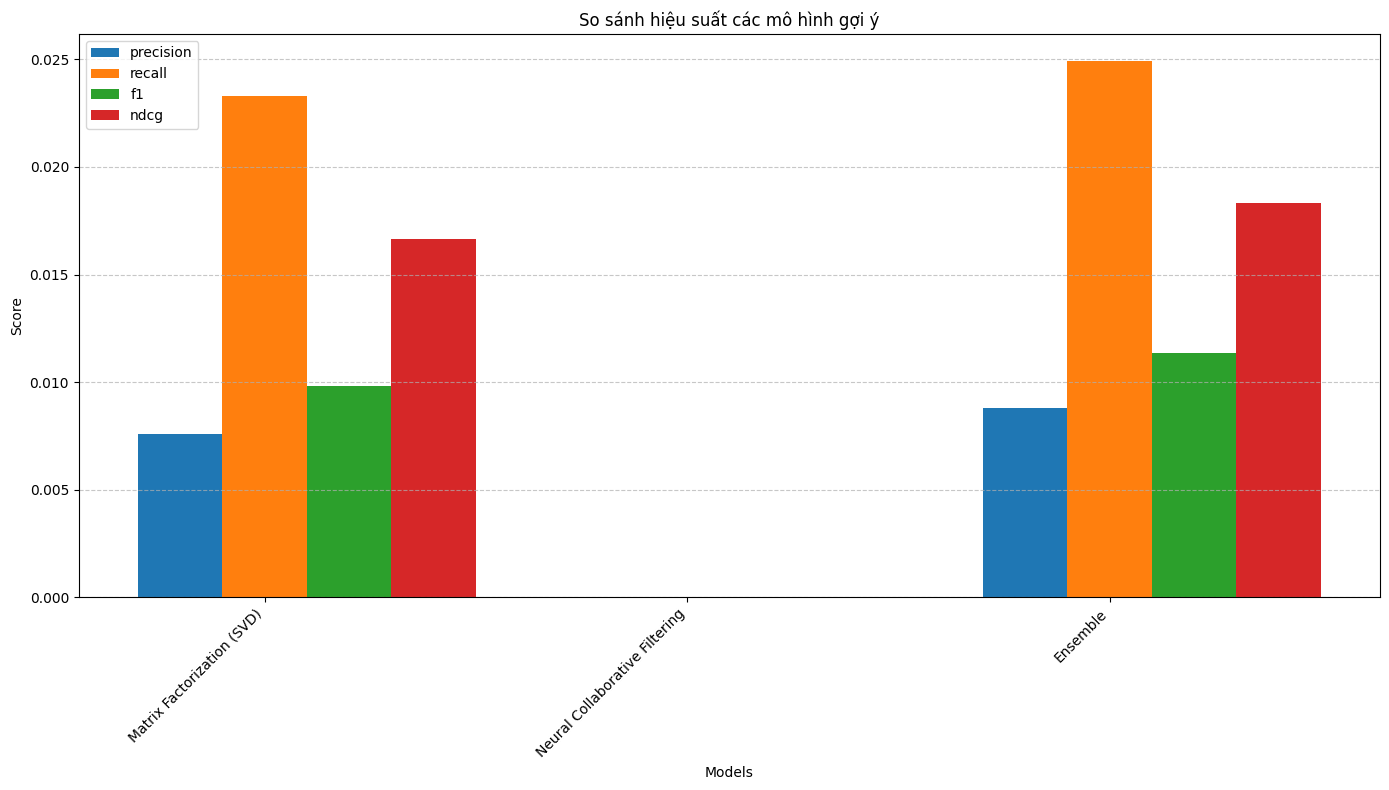

In [213]:
# Xây dựng mô hình kết hợp toàn diện
def ensemble_recommendations(user_id, k=5):
    """Gợi ý sách bằng cách kết hợp nhiều mô hình
    
    Kết hợp: NCF, SVD, Content-Based NLP, và KNN với trọng số khác nhau
    """
    try:
        # Lấy gợi ý từ các mô hình khác nhau
        ncf_recs = ncf_recommendations(user_id, k*2)
        svd_recs = svd_recommendations(user_id, k*2)
        nlp_recs = nlp_recommendations(user_id, k*2)
        knn_recs = collaborative_recommendations(user_id, k*2)
        
        # Tính điểm cho mỗi sách
        book_scores = {}
        
        # Trọng số cho mỗi mô hình (có thể điều chỉnh)
        weights = {
            'ncf': 0.4,    # Trọng số cao nhất cho NCF
            'svd': 0.3,    # Trọng số cao cho SVD
            'nlp': 0.2,    # Trọng số trung bình cho NLP
            'knn': 0.1     # Trọng số thấp cho KNN
        }
        
        # Thêm điểm cho các sách được gợi ý từ NCF
        for i, isbn in enumerate(ncf_recs):
            score = weights['ncf'] * (1.0 - i/(k*2))
            book_scores[isbn] = book_scores.get(isbn, 0) + score
        
        # Thêm điểm cho các sách được gợi ý từ SVD
        for i, isbn in enumerate(svd_recs):
            score = weights['svd'] * (1.0 - i/(k*2))
            book_scores[isbn] = book_scores.get(isbn, 0) + score
        
        # Thêm điểm cho các sách được gợi ý từ NLP
        for i, isbn in enumerate(nlp_recs):
            score = weights['nlp'] * (1.0 - i/(k*2))
            book_scores[isbn] = book_scores.get(isbn, 0) + score
        
        # Thêm điểm cho các sách được gợi ý từ KNN
        for i, isbn in enumerate(knn_recs):
            score = weights['knn'] * (1.0 - i/(k*2))
            book_scores[isbn] = book_scores.get(isbn, 0) + score
        
        # Sắp xếp theo điểm giảm dần
        sorted_books = sorted(book_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Trả về k sách có điểm cao nhất
        return [book[0] for book in sorted_books[:k]]
    
    except:
        # Fallback: trả về sách phổ biến
        return popularity_recommendations(user_id, k)

# Test ensemble recommender
test_user = users['User-ID'].iloc[0]
print(f"Gợi ý cho user {test_user} bằng Ensemble:")
recommendations = ensemble_recommendations(test_user, k=5)
for i, isbn in enumerate(recommendations):
    if isbn in books['ISBN'].values:
        title = books[books['ISBN'] == isbn]['Book-Title'].values[0]
        author = books[books['ISBN'] == isbn]['Book-Author'].values[0]
        print(f"{i+1}. {title} by {author}")
    else:
        print(f"{i+1}. Unknown book (ISBN: {isbn})")

# Thêm ensemble recommender vào danh sách đánh giá
models['Ensemble'] = ensemble_recommendations

# Đánh giá ensemble recommender
print("\nĐánh giá Ensemble Model...")
metrics = evaluate_recommender(ensemble_recommendations, test_data, k=5)
results['Ensemble'] = metrics

print(f"  - Precision@5: {metrics['precision']:.4f}")
print(f"  - Recall@5: {metrics['recall']:.4f}")
print(f"  - F1@5: {metrics['f1']:.4f}")
print(f"  - NDCG@5: {metrics['ndcg']:.4f}")

# Cập nhật bảng so sánh cuối cùng
results_df = pd.DataFrame(results).T
print("\nSo sánh hiệu suất tất cả các mô hình:")
print(results_df)

# Trực quan hóa so sánh
plt.figure(figsize=(14, 8))
metrics = ['precision', 'recall', 'f1', 'ndcg']
x = np.arange(len(results))
width = 0.2
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    plt.bar(x + offset, results_df[metric], width, label=metric)
    multiplier += 1

plt.title('So sánh hiệu suất các mô hình gợi ý')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(x + width, results_df.index, rotation=45, ha='right')
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [214]:
#Đánh giá mô hình

In [215]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
import numpy as np

def calculate_precision_at_k(recommended_items, relevant_items, k=5):
    """Tính precision@k: tỷ lệ item được gợi ý nằm trong danh sách relevant"""
    if len(recommended_items) == 0:
        return 0.0
    count = 0
    for i in range(min(k, len(recommended_items))):
        if recommended_items[i] in relevant_items:
            count += 1
    return count / k

def calculate_recall_at_k(recommended_items, relevant_items, k=5):
    """Tính recall@k: tỷ lệ relevant items được gợi ý đúng"""
    if len(relevant_items) == 0:
        return 0.0
    count = 0
    for i in range(min(k, len(recommended_items))):
        if recommended_items[i] in relevant_items:
            count += 1
    return count / len(relevant_items)

def calculate_ndcg_at_k(recommended_items, relevant_items, k=5):
    """Tính NDCG (Normalized Discounted Cumulative Gain)"""
    if len(recommended_items) == 0 or len(relevant_items) == 0:
        return 0.0

    # Tạo relevance vector (1 nếu item nằm trong relevant_items, 0 nếu không)
    relevance = [1 if item in relevant_items else 0 for item in recommended_items[:k]]
    
    # Tính DCG (Discounted Cumulative Gain)
    dcg = relevance[0] + sum([rel / np.log2(i + 2) for i, rel in enumerate(relevance[1:])])
    
    # Tính IDCG (Ideal DCG)
    ideal_relevance = [1] * min(k, len(relevant_items)) + [0] * max(0, k - len(relevant_items))
    idcg = ideal_relevance[0] + sum([rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance[1:])])
    
    if idcg == 0:
        return 0.0
    
    return dcg / idcg

In [216]:
def evaluate_recommender(recommender_function, test_data, k=5):
    """Đánh giá hiệu suất của một hệ thống gợi ý
    
    Args:
        recommender_function: Hàm gợi ý trả về list các item được gợi ý
        test_data: DataFrame với cột User-ID, ISBN, Book-Rating
        k: Số lượng item gợi ý đánh giá
        
    Returns:
        Dict chứa các metrics: precision, recall, f1, ndcg
    """
    # Lấy tất cả user trong tập test
    users = test_data['User-ID'].unique()
    
    # Khởi tạo metrics
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0
    count = 0
    
    for user in users[:100]:  # Giới hạn 100 users để tăng tốc đánh giá
        # Lấy sách người dùng đã đánh giá tốt (rating >= 7) làm ground truth
        relevant_items = test_data[(test_data['User-ID'] == user) & 
                                  (test_data['Book-Rating'] >= 7)]['ISBN'].tolist()
        
        if len(relevant_items) == 0:
            continue
            
        # Gọi hàm gợi ý để lấy danh sách sách được gợi ý
        try:
            recommended_items = recommender_function(user, k)
            
            # Tính các metrics
            precision = calculate_precision_at_k(recommended_items, relevant_items, k)
            recall = calculate_recall_at_k(recommended_items, relevant_items, k)
            ndcg = calculate_ndcg_at_k(recommended_items, relevant_items, k)
            
            precision_sum += precision
            recall_sum += recall
            ndcg_sum += ndcg
            count += 1
        except:
            continue
    
    if count == 0:
        return {'precision': 0, 'recall': 0, 'f1': 0, 'ndcg': 0}
    
    # Tính trung bình
    precision_avg = precision_sum / count
    recall_avg = recall_sum / count
    f1_avg = 2 * precision_avg * recall_avg / (precision_avg + recall_avg) if precision_avg + recall_avg > 0 else 0
    ndcg_avg = ndcg_sum / count
    
    return {
        'precision': precision_avg,
        'recall': recall_avg,
        'f1': f1_avg,
        'ndcg': ndcg_avg
    }

Đánh giá các mô hình...
Đánh giá mô hình Popularity-based...
  - Precision@5: 0.0089
  - Recall@5: 0.0027
  - F1@5: 0.0041
  - NDCG@5: 0.0102
Đánh giá mô hình Collaborative Filtering (KNN)...
  - Precision@5: 0.0000
  - Recall@5: 0.0000
  - F1@5: 0.0000
  - NDCG@5: 0.0000
Đánh giá mô hình Content-based...
  - Precision@5: 0.0000
  - Recall@5: 0.0000
  - F1@5: 0.0000
  - NDCG@5: 0.0000
Đánh giá mô hình Hybrid...
  - Precision@5: 0.0000
  - Recall@5: 0.0000
  - F1@5: 0.0000
  - NDCG@5: 0.0000

So sánh hiệu suất các mô hình:
                               precision    recall       f1      ndcg
Popularity-based               0.008889   0.002681  0.00412  0.010176
Collaborative Filtering (KNN)  0.000000   0.000000  0.00000  0.000000
Content-based                  0.000000   0.000000  0.00000  0.000000
Hybrid                         0.000000   0.000000  0.00000  0.000000


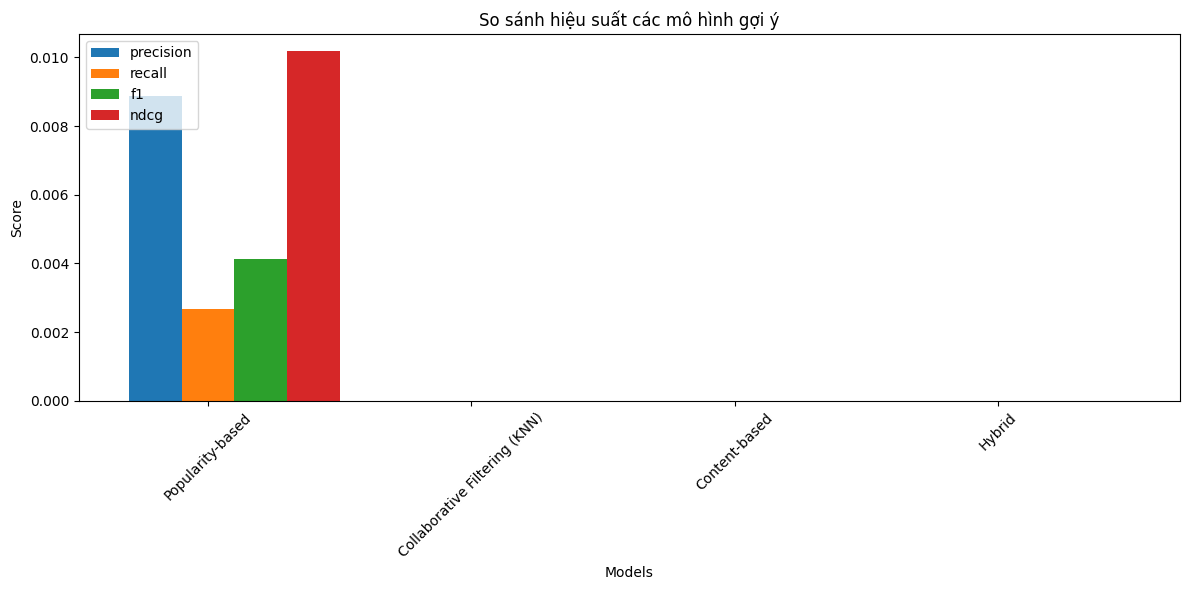

In [217]:
# Định nghĩa các hàm gợi ý khác nhau để đánh giá
def popularity_recommendations(user_id, k=5):
    # Implementation của popularity-based recommender
    # Trả về list ISBN của k sách phổ biến nhất
    popular_books = popularity_based(dataset1, k).reset_index()
    return popular_books['ISBN'].tolist()

def collaborative_recommendations(user_id, k=5):
    # Implementation của collaborative filtering recommender
    # Sử dụng mô hình KNN đã huấn luyện để gợi ý
    # Cần điều chỉnh để phù hợp với implementation của bạn
    if user_id not in user_to_idx:
        return popularity_recommendations(user_id, k)  # Fallback nếu user mới
    
    # Lấy các item chưa được user đánh giá
    rated_items = train_data[train_data['User-ID'] == user_id]['ISBN'].unique()
    all_items = list(isbn_to_idx.keys())
    unrated_items = [item for item in all_items if item not in rated_items]
    
    # Dự đoán rating cho các item chưa đánh giá
    predictions = []
    for item in unrated_items[:100]:  # Giới hạn 100 item để tăng tốc
        if item in isbn_to_idx:
            pred = best_recommender.predict(user_to_idx[user_id], isbn_to_idx[item])
            predictions.append((item, pred))
    
    # Sắp xếp theo rating dự đoán giảm dần và trả về k item hàng đầu
    predictions.sort(key=lambda x: x[1], reverse=True)
    return [p[0] for p in predictions[:k]]

def content_recommendations(user_id, k=5):
    # Implementation của content-based recommender
    # Để đơn giản, có thể sửa lại hàm getTopRecommandations để phù hợp
    # hoặc sử dụng phương pháp tìm kiếm tương tự dựa trên TF-IDF
    # ...
    # Hiện tại giả sử ta có hàm tương tự như collaborative
    return collaborative_recommendations(user_id, k)  # Placeholder

def hybrid_recommendations(user_id, k=5):
    # Implementation của hybrid recommender
    # Có thể kết hợp kết quả từ collaborative và content-based
    collab_items = collaborative_recommendations(user_id, k)
    content_items = content_recommendations(user_id, k)
    
    # Kết hợp kết quả, ưu tiên các item xuất hiện ở cả hai phương pháp
    combined = {}
    for i, item in enumerate(collab_items):
        combined[item] = combined.get(item, 0) + (k - i) / k
    
    for i, item in enumerate(content_items):
        combined[item] = combined.get(item, 0) + (k - i) / (2 * k)  # Trọng số 0.5
    
    # Sắp xếp theo score giảm dần
    sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)
    return [item[0] for item in sorted_items[:k]]

# Đánh giá tất cả các mô hình
print("Đánh giá các mô hình...")
models = {
    'Popularity-based': popularity_recommendations,
    'Collaborative Filtering (KNN)': collaborative_recommendations,
    'Content-based': content_recommendations,
    'Hybrid': hybrid_recommendations
}

results = {}
for name, model in models.items():
    print(f"Đánh giá mô hình {name}...")
    metrics = evaluate_recommender(model, test_data, k=5)
    results[name] = metrics
    print(f"  - Precision@5: {metrics['precision']:.4f}")
    print(f"  - Recall@5: {metrics['recall']:.4f}")
    print(f"  - F1@5: {metrics['f1']:.4f}")
    print(f"  - NDCG@5: {metrics['ndcg']:.4f}")

# Hiển thị kết quả dạng bảng
import pandas as pd
results_df = pd.DataFrame(results).T
print("\nSo sánh hiệu suất các mô hình:")
print(results_df)

# Trực quan hóa kết quả
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

metrics = ['precision', 'recall', 'f1', 'ndcg']
x = np.arange(len(models))
width = 0.2
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    values = [results[model][metric] for model in models]
    plt.bar(x + offset, values, width, label=metric)
    multiplier += 1

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('So sánh hiệu suất các mô hình gợi ý')
plt.xticks(x + width, models.keys(), rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [218]:
#cross-validation

In [219]:
from sklearn.model_selection import KFold

# Cài đặt k-fold cross-validation
print("Cài đặt k-fold cross-validation...")

def cross_validate(recommender_class, params, ratings_data, n_splits=5, k=5):
    """Thực hiện cross-validation cho mô hình gợi ý
    
    Args:
        recommender_class: Class của mô hình gợi ý
        params: Dict các tham số cho mô hình
        ratings_data: DataFrame chứa ratings
        n_splits: Số lượng fold
        k: Số lượng items trong gợi ý để đánh giá
        
    Returns:
        Dict chứa các metrics trung bình: precision, recall, f1, ndcg
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Tạo các fold
    fold_metrics = []
    
    # Lấy user IDs để chia theo users
    users = ratings_data['User-ID'].unique()
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(users)):
        print(f"Fold {fold+1}/{n_splits}")
        
        # Chia tập dữ liệu
        train_users = users[train_idx]
        test_users = users[test_idx]
        
        train_data = ratings_data[ratings_data['User-ID'].isin(train_users)]
        test_data = ratings_data[ratings_data['User-ID'].isin(test_users)]
        
        # Đảm bảo mỗi user trong test có ít nhất 1 rating trong train
        for user in test_users:
            user_ratings = ratings_data[ratings_data['User-ID'] == user]
            if len(user_ratings) > 1:
                sample_for_train = user_ratings.sample(1)
                train_data = pd.concat([train_data, sample_for_train])
                test_data = test_data[~test_data.index.isin(sample_for_train.index)]
        
        # Khởi tạo và huấn luyện mô hình
        model = recommender_class(**params)
        model.fit(train_data)
        
        # Hàm gợi ý để đánh giá
        def recommend_function(user_id, k):
            try:
                return model.recommend(user_id, k)
            except:
                return []
        
        # Đánh giá mô hình
        metrics = evaluate_recommender(recommend_function, test_data, k=k)
        fold_metrics.append(metrics)
        
        print(f"  - Precision@{k}: {metrics['precision']:.4f}")
        print(f"  - Recall@{k}: {metrics['recall']:.4f}")
        print(f"  - F1@{k}: {metrics['f1']:.4f}")
        print(f"  - NDCG@{k}: {metrics['ndcg']:.4f}")
    
    # Tính metrics trung bình
    avg_metrics = {
        'precision': np.mean([m['precision'] for m in fold_metrics]),
        'recall': np.mean([m['recall'] for m in fold_metrics]),
        'f1': np.mean([m['f1'] for m in fold_metrics]),
        'ndcg': np.mean([m['ndcg'] for m in fold_metrics])
    }
    
    std_metrics = {
        'precision_std': np.std([m['precision'] for m in fold_metrics]),
        'recall_std': np.std([m['recall'] for m in fold_metrics]),
        'f1_std': np.std([m['f1'] for m in fold_metrics]),
        'ndcg_std': np.std([m['ndcg'] for m in fold_metrics])
    }
    
    return {**avg_metrics, **std_metrics}

Cài đặt k-fold cross-validation...


In [220]:
# Lớp KNN Recommender để cross-validate
class KNNRecommender:
    def __init__(self, n_neighbors=10, metric='cosine', algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.algorithm = algorithm
        self.model = None
        self.train_data = None
        self.user_to_idx = None
        self.isbn_to_idx = None
        self.user_ids = None
        self.isbn_ids = None
    
    def fit(self, train_data):
        # Chuẩn bị dữ liệu
        self.train_data = train_data
        
        # Tạo ánh xạ user và item IDs sang indices
        self.user_ids = list(train_data['User-ID'].unique())
        self.isbn_ids = list(train_data['ISBN'].unique())
        
        self.user_to_idx = {user: idx for idx, user in enumerate(self.user_ids)}
        self.isbn_to_idx = {isbn: idx for idx, isbn in enumerate(self.isbn_ids)}
        
        # Tạo sparse matrix
        row_indices = [self.user_to_idx[user] for user in train_data['User-ID']]
        col_indices = [self.isbn_to_idx[isbn] for isbn in train_data['ISBN']]
        data_values = train_data['Book-Rating'].values
        
        self.train_matrix = csr_matrix((data_values, (row_indices, col_indices)), 
                                      shape=(len(self.user_ids), len(self.isbn_ids)))
        
        # Huấn luyện mô hình
        self.model = NearestNeighbors(
            n_neighbors=self.n_neighbors,
            metric=self.metric,
            algorithm=self.algorithm
        )
        self.model.fit(self.train_matrix)
        
        return self
    
    def predict(self, user_id, isbn):
        if user_id not in self.user_to_idx or isbn not in self.isbn_to_idx:
            return 0
        
        user_idx = self.user_to_idx[user_id]
        item_idx = self.isbn_to_idx[isbn]
        
        # Lấy vector user
        user_vector = self.train_matrix[user_idx].toarray().reshape(1, -1)
        
        # Tìm k láng giếng gần nhất
        _, indices = self.model.kneighbors(user_vector)
        
        # Lấy rating trung bình cho item từ các láng giềng
        neighbors_ratings = []
        for neighbor_idx in indices[0]:
            if neighbor_idx == user_idx:
                continue
            
            neighbor_id = self.user_ids[neighbor_idx]
            
            neighbor_rating = self.train_data[
                (self.train_data['User-ID'] == neighbor_id) & 
                (self.train_data['ISBN'] == isbn)
            ]
            
            if len(neighbor_rating) > 0:
                neighbors_ratings.append(neighbor_rating['Book-Rating'].values[0])
        
        # Nếu không có láng giềng nào đánh giá item này
        if not neighbors_ratings:
            return self.train_data['Book-Rating'].mean()
        
        return np.mean(neighbors_ratings)
    
    def recommend(self, user_id, k=5):
        if user_id not in self.user_to_idx:
            # Nếu là user mới, trả về sách phổ biến
            return popularity_recommendations(user_id, k)
        
        user_idx = self.user_to_idx[user_id]
        
        # Lấy sách đã đọc của user
        rated_items = self.train_data[self.train_data['User-ID'] == user_id]['ISBN'].unique()
        
        # Lấy vector user
        user_vector = self.train_matrix[user_idx].toarray().reshape(1, -1)
        
        # Tìm k láng giếng gần nhất
        _, indices = self.model.kneighbors(user_vector)
        
        # Tạo dict để lưu predictions
        predictions = {}
        
        # Dự đoán rating cho các items chưa đọc
        for isbn in self.isbn_ids:
            if isbn not in rated_items:
                prediction = self.predict(user_id, isbn)
                predictions[isbn] = prediction
        
        # Sắp xếp và lấy k items có rating cao nhất
        sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
        recommended_items = [item[0] for item in sorted_predictions[:k]]
        
        return recommended_items

# Lớp SVD Recommender để cross-validate
class SVDRecommenderCV:
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.U = None
        self.Vt = None
        self.user_to_idx = None
        self.isbn_to_idx = None
        self.user_ids = None
        self.isbn_ids = None
    
    def fit(self, train_data):
        # Chuẩn bị dữ liệu
        sparse_matrix, self.user_to_idx, self.isbn_to_idx, self.user_ids, self.isbn_ids = create_user_item_matrix(train_data)
        
        # Khởi tạo và huấn luyện mô hình SVD
        svd = TruncatedSVD(n_components=self.n_factors, random_state=42)
        self.U = svd.fit_transform(sparse_matrix)
        self.Vt = svd.components_
        
        return self
    
    def predict(self, user_id, isbn):
        if user_id not in self.user_to_idx or isbn not in self.isbn_to_idx:
            return 0
        
        user_idx = self.user_to_idx[user_id]
        item_idx = self.isbn_to_idx[isbn]
        
        # Dự đoán rating = u_i * v_j^T
        prediction = np.dot(self.U[user_idx, :], self.Vt[:, item_idx])
        
        # Giới hạn trong khoảng 0-10
        return max(0, min(10, prediction))
    
    def recommend(self, user_id, k=5):
        if user_id not in self.user_to_idx:
            # Nếu là user mới, trả về sách phổ biến
            return popularity_recommendations(user_id, k)
        
        user_idx = self.user_to_idx[user_id]
        user_vector = self.U[user_idx, :]
        
        # Dự đoán rating cho tất cả items
        predictions = user_vector.dot(self.Vt)
        
        # Lấy k indices có rating cao nhất
        top_item_indices = np.argsort(predictions)[-k:][::-1]
        
        # Convert indices sang ISBN
        recommended_items = [self.isbn_ids[idx] for idx in top_item_indices]
        
        return recommended_items

In [221]:
# Thực hiện cross-validation cho KNN
print("Thực hiện cross-validation cho KNN Recommender...")
knn_params = {
    'n_neighbors': 10,
    'metric': 'cosine',
    'algorithm': 'brute'
}

knn_cv_results = cross_validate(KNNRecommender, knn_params, explicit_ratings.sample(frac=0.1, random_state=42), n_splits=3, k=5)

print("\nKết quả cross-validation cho KNN Recommender:")
print(f"Precision@5: {knn_cv_results['precision']:.4f} ± {knn_cv_results['precision_std']:.4f}")
print(f"Recall@5: {knn_cv_results['recall']:.4f} ± {knn_cv_results['recall_std']:.4f}")
print(f"F1@5: {knn_cv_results['f1']:.4f} ± {knn_cv_results['f1_std']:.4f}")
print(f"NDCG@5: {knn_cv_results['ndcg']:.4f} ± {knn_cv_results['ndcg_std']:.4f}")

# Thực hiện cross-validation cho SVD
print("\nThực hiện cross-validation cho SVD Recommender...")
svd_params = {
    'n_factors': 50
}

svd_cv_results = cross_validate(SVDRecommenderCV, svd_params, explicit_ratings.sample(frac=0.1, random_state=42), n_splits=3, k=5)

print("\nKết quả cross-validation cho SVD Recommender:")
print(f"Precision@5: {svd_cv_results['precision']:.4f} ± {svd_cv_results['precision_std']:.4f}")
print(f"Recall@5: {svd_cv_results['recall']:.4f} ± {svd_cv_results['recall_std']:.4f}")
print(f"F1@5: {svd_cv_results['f1']:.4f} ± {svd_cv_results['f1_std']:.4f}")
print(f"NDCG@5: {svd_cv_results['ndcg']:.4f} ± {svd_cv_results['ndcg_std']:.4f}")

# So sánh kết quả
cv_comparison = pd.DataFrame({
    'KNN': [
        f"{knn_cv_results['precision']:.4f} ± {knn_cv_results['precision_std']:.4f}",
        f"{knn_cv_results['recall']:.4f} ± {knn_cv_results['recall_std']:.4f}",
        f"{knn_cv_results['f1']:.4f} ± {knn_cv_results['f1_std']:.4f}",
        f"{knn_cv_results['ndcg']:.4f} ± {knn_cv_results['ndcg_std']:.4f}"
    ],
    'SVD': [
        f"{svd_cv_results['precision']:.4f} ± {svd_cv_results['precision_std']:.4f}",
        f"{svd_cv_results['recall']:.4f} ± {svd_cv_results['recall_std']:.4f}",
        f"{svd_cv_results['f1']:.4f} ± {svd_cv_results['f1_std']:.4f}",
        f"{svd_cv_results['ndcg']:.4f} ± {svd_cv_results['ndcg_std']:.4f}"
    ]
}, index=['Precision@5', 'Recall@5', 'F1@5', 'NDCG@5'])

print("\nSo sánh kết quả cross-validation:")
print(cv_comparison)

Thực hiện cross-validation cho KNN Recommender...
Fold 1/3
  - Precision@5: 0.0025
  - Recall@5: 0.0123
  - F1@5: 0.0041
  - NDCG@5: 0.0123
Fold 2/3
  - Precision@5: 0.0022
  - Recall@5: 0.0112
  - F1@5: 0.0037
  - NDCG@5: 0.0071
Fold 3/3
  - Precision@5: 0.0023
  - Recall@5: 0.0015
  - F1@5: 0.0018
  - NDCG@5: 0.0014

Kết quả cross-validation cho KNN Recommender:
Precision@5: 0.0023 ± 0.0001
Recall@5: 0.0083 ± 0.0049
F1@5: 0.0032 ± 0.0010
NDCG@5: 0.0069 ± 0.0045

Thực hiện cross-validation cho SVD Recommender...
Fold 1/3
  - Precision@5: 0.0049
  - Recall@5: 0.0247
  - F1@5: 0.0082
  - NDCG@5: 0.0185
Fold 2/3
  - Precision@5: 0.0023
  - Recall@5: 0.0114
  - F1@5: 0.0038
  - NDCG@5: 0.0072
Fold 3/3
  - Precision@5: 0.0023
  - Recall@5: 0.0023
  - F1@5: 0.0023
  - NDCG@5: 0.0032

Kết quả cross-validation cho SVD Recommender:
Precision@5: 0.0032 ± 0.0013
Recall@5: 0.0128 ± 0.0092
F1@5: 0.0048 ± 0.0025
NDCG@5: 0.0096 ± 0.0065

So sánh kết quả cross-validation:
                         KNN